In [1]:
import numpy as np
import torch
import sys
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import pandas as pd

from torch.utils.data import DataLoader, Dataset, TensorDataset

import time
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [3]:
!ls

!pwd

Lung12_generate.ipynb	   Lung5_Rep2_generate.ipynb  Lung9_Rep1_generate.ipynb
Lung13_generate.ipynb	   Lung5_Rep3_generate.ipynb  Lung9_Rep2_generate.ipynb
Lung5_Rep1_generate.ipynb  Lung6_generate.ipynb       notes.txt
/mnt/ufs18/home-144/dingjia5/projects/CosMx_lung/benchmark_generation_scripts


# Transcript Data

In [4]:
import pandas as pd


In [5]:
gene_spatial = pd.read_csv('../Lung13/Lung13-Flat_files_and_images/Lung13_tx_file.csv')
gene_spatial

fov  cell_ID   x_global_px   y_global_px   x_local_px   y_local_px  \
0           1        0 -35139.016567   -485.447222  2977.650100  3286.775000   
1           1        0 -35070.606667  -1331.982222  3046.060000  2440.240000   
2           1        0 -34639.466667  -1726.142122  3477.200000  2046.080100   
3           1        0 -33055.041667  -1961.022222  5061.625000  1811.200000   
4           1        0 -35112.416667  -2353.488822  3004.250000  1418.733400   
...       ...      ...           ...           ...          ...          ...   
29995453   20     4005 -17513.174805  10840.677680  4186.825195    12.899902   
29995454   20     4005 -17514.783203  10843.444526  4185.216797    15.666748   
29995455   20     4005 -17527.224609  10841.177680  4172.775391    13.399902   
29995456   20     4005 -17514.750000  10841.510932  4185.250000    13.733154   
29995457   20     4005 -17529.517090  10840.961127  4170.482910    13.183350   

          z   target   CellComp  
0         6    NEAT1    Nuclear  
1         6  S100A10          0  
2         6     IL7R   Membrane  
3         6      VWF   Membrane  
4         6  S100A10   Membrane  
...      ..      ...        ...  
29995453  2   COL3A1  Cytoplasm  
29995454  2    CALM2  Cytoplasm  
29995455  2    IL1R1    Nuclear  
29995456  2    HLA-B  Cytoplasm  
29995457  2     TPM2    Nuclear  

[29995458 rows x 9 columns]

In [6]:
gene_spatial.loc[gene_spatial['fov']==1]

fov  cell_ID   x_global_px  y_global_px   x_local_px   y_local_px  z  \
0          1        0 -35139.016567  -485.447222  2977.650100  3286.775000  6   
1          1        0 -35070.606667 -1331.982222  3046.060000  2440.240000  6   
2          1        0 -34639.466667 -1726.142122  3477.200000  2046.080100  6   
3          1        0 -33055.041667 -1961.022222  5061.625000  1811.200000  6   
4          1        0 -35112.416667 -2353.488822  3004.250000  1418.733400  6   
...      ...      ...           ...          ...          ...          ... ..   
1626910    1     3587 -34926.141764 -3753.372369  3190.524902    18.849854  7   
1626911    1     3587 -34946.646403 -3755.162164  3170.020264    17.060059  7   
1626912    1     3588 -32852.536784 -3755.651910  5264.129883    16.570312  2   
1626913    1     3588 -32879.632975 -3759.355279  5237.033691    12.866943  2   
1626914    1     3588 -32852.724284 -3755.436578  5263.942383    16.785645  1   

          target   CellComp  
0          NEAT1    Nuclear  
1        S100A10          0  
2           IL7R   Membrane  
3            VWF   Membrane  
4        S100A10   Membrane  
...          ...        ...  
1626910     CD74    Nuclear  
1626911    DUSP5  Cytoplasm  
1626912      MAF  Cytoplasm  
1626913   IGFBP6    Nuclear  
1626914      MAF  Cytoplasm  

[1626915 rows x 9 columns]

In [7]:
filtered_data_fov1_cell_ID_1 =  gene_spatial[(gene_spatial['fov']==1) & (gene_spatial['cell_ID']==1)]
filtered_data_fov1_cell_ID_1

fov  cell_ID   x_global_px  y_global_px  x_local_px   y_local_px  z  \
498835    1        1 -37818.966667  -164.055554  297.700000  3608.166668  6   
498836    1        1 -37794.616667  -150.047222  322.050000  3622.175000  6   
498837    1        1 -37811.757567  -145.231314  304.909100  3626.990908  6   
498838    1        1 -37830.626687  -159.182222  286.039980  3613.040000  6   
498839    1        1 -37814.599987  -164.172222  302.066680  3608.050000  6   
...     ...      ...           ...          ...         ...          ... ..   
498928    1        1 -37833.806651  -151.762225  282.860016  3620.459997  7   
498929    1        1 -37820.891642  -165.572221  295.775024  3606.650002  7   
498930    1        1 -37828.786692  -165.162225  287.879974  3607.059998  7   
498931    1        1 -37789.226664  -136.182222  327.440002  3636.040000  7   
498932    1        1 -37823.483317  -167.588891  293.183350  3604.633331  7   

          target   CellComp  
498835      CD34  Cytoplasm  
498836       GSN  Cytoplasm  
498837     HSPB1    Nuclear  
498838     KRT15  Cytoplasm  
498839  SERPINA1  Cytoplasm  
...          ...        ...  
498928     MZT2A   Membrane  
498929      PSAP  Cytoplasm  
498930      ARF1  Cytoplasm  
498931    MALAT1  Cytoplasm  
498932     KRT15  Cytoplasm  

[98 rows x 9 columns]

In [8]:
gene_expression = pd.read_csv('../Lung13/Lung13-Flat_files_and_images/Lung13_exprMat_file.csv')
gene_expression

fov  cell_ID  AATK  ABL1  ABL2  ACE  ACE2  ACKR1  ACKR3  ACKR4  ...  \
0        1        0    79   215   275  173   131    108    122    115  ...   
1        1        1     0     0     0    0     0      0      0      0  ...   
2        1        2     0     0     0    0     0      0      0      0  ...   
3        1        3     0     0     0    0     0      0      0      0  ...   
4        1        4     0     0     0    0     0      0      0      0  ...   
...    ...      ...   ...   ...   ...  ...   ...    ...    ...    ...  ...   
82858   20     4001     0     0     0    0     0      0      0      0  ...   
82859   20     4002     0     0     0    0     0      0      0      0  ...   
82860   20     4003     0     0     0    0     0      0      0      0  ...   
82861   20     4004     0     0     0    0     0      0      0      0  ...   
82862   20     4005     0     0     0    0     0      0      0      0  ...   

       NegPrb14  NegPrb15  NegPrb16  NegPrb17  NegPrb18  NegPrb19  NegPrb20  \
0           139        77       115       117       115       142       173   
1             0         0         0         0         0         0         0   
2             0         0         0         0         0         0         0   
3             0         0         0         0         0         0         0   
4             0         0         0         0         0         0         0   
...         ...       ...       ...       ...       ...       ...       ...   
82858         1         0         0         0         0         0         0   
82859         0         0         0         0         0         0         0   
82860         0         0         0         0         0         0         0   
82861         0         0         0         0         0         0         0   
82862         0         0         0         0         0         0         0   

       NegPrb21  NegPrb22  NegPrb23  
0           136       129       123  
1             0         0         0  
2             0         0         0  
3             0         0         0  
4             0         0         0  
...         ...       ...       ...  
82858         0         0         0  
82859         0         0         0  
82860         0         0         0  
82861         0         0         0  
82862         0         0         0  

[82863 rows x 982 columns]

In [9]:
cell_boundary = pd.read_csv('../Lung13/Lung13-Flat_files_and_images/Lung13_metadata_file.csv')
cell_boundary


fov  cell_ID  Area  AspectRatio  CenterX_local_px  CenterY_local_px  \
0        1        1  3703         1.69               290              3622   
1        1        2  2383         2.88               609              3632   
2        1        3  1937         2.09               806              3631   
3        1        4  1551         1.18               983              3628   
4        1        5  1895         1.50              1109              3629   
...    ...      ...   ...          ...               ...               ...   
82838   20     4001  2829         2.75              2588                19   
82839   20     4002  1923         3.03              1219                16   
82840   20     4003  1156         2.12              2149                14   
82841   20     4004   839         2.33              4515                12   
82842   20     4005   682         1.70              4170                13   

       CenterX_global_px  CenterY_global_px  Width  Height  \
0          -37826.666667        -150.222222     88      52   
1          -37507.666667        -140.222222     92      32   
2          -37310.666667        -141.222222     73      35   
3          -37133.666667        -144.222222     47      40   
4          -37007.666667        -143.222222     57      38   
...                  ...                ...    ...     ...   
82838      -19112.000000       10846.777778     99      36   
82839      -20481.000000       10843.777778     91      30   
82840      -19551.000000       10841.777778     55      26   
82841      -17185.000000       10839.777778     49      21   
82842      -17530.000000       10840.777778     39      23   

       Mean.MembraneStain  Max.MembraneStain  Mean.PanCK  Max.PanCK  \
0                    2297               4545        4185      13854   
1                    3619               5831        6416      17592   
2                    2545               4550           0         35   
3                    5585              12901           0          0   
4                    4047              14116           0         76   
...                   ...                ...         ...        ...   
82838                5158              10180         634       2166   
82839                4000              15522          48       2460   
82840                6339               9804         211        570   
82841                3491               5600         203        481   
82842                3818               6387         211        444   

       Mean.CD45  Max.CD45  Mean.CD3  Max.CD3  Mean.DAPI  Max.DAPI  
0             49       865        77      391         38       372  
1             35      1059        45      826        114       531  
2             22       935         5      133        160       475  
3             50      1283       126      669        353       899  
4             25      1294       148      895        395       878  
...          ...       ...       ...      ...        ...       ...  
82838         41       304        39      304        888      2144  
82839        554      1593       162      780        536      2118  
82840        488      1269       233      583        704      1588  
82841        335       779       109      444        185       461  
82842        259       571        98      393        256       949  

[82843 rows x 20 columns]

In [10]:
cell_boundary_fov_1 =  cell_boundary[(cell_boundary['fov']==1)]
cell_boundary_fov_1

fov  cell_ID  Area  AspectRatio  CenterX_local_px  CenterY_local_px  \
0       1        1  3703         1.69               290              3622   
1       1        2  2383         2.88               609              3632   
2       1        3  1937         2.09               806              3631   
3       1        4  1551         1.18               983              3628   
4       1        5  1895         1.50              1109              3629   
...   ...      ...   ...          ...               ...               ...   
3583    1     3584  3782         1.88              5086                27   
3584    1     3585  2174         1.19              2610                25   
3585    1     3586  1085         1.28              2211                17   
3586    1     3587  1914         1.97              3202                18   
3587    1     3588  1359         1.88              5244                17   

      CenterX_global_px  CenterY_global_px  Width  Height  Mean.MembraneStain  \
0         -37826.666667        -150.222222     88      52                2297   
1         -37507.666667        -140.222222     92      32                3619   
2         -37310.666667        -141.222222     73      35                2545   
3         -37133.666667        -144.222222     47      40                5585   
4         -37007.666667        -143.222222     57      38                4047   
...                 ...                ...    ...     ...                 ...   
3583      -33030.666667       -3745.222222     96      51                 498   
3584      -35506.666667       -3747.222222     56      47                 700   
3585      -35905.666667       -3755.222222     41      32                2118   
3586      -34914.666667       -3754.222222     65      33                 786   
3587      -32872.666667       -3755.222222     60      32                1939   

      Max.MembraneStain  Mean.PanCK  Max.PanCK  Mean.CD45  Max.CD45  Mean.CD3  \
0                  4545        4185      13854         49       865        77   
1                  5831        6416      17592         35      1059        45   
2                  4550           0         35         22       935         5   
3                 12901           0          0         50      1283       126   
4                 14116           0         76         25      1294       148   
...                 ...         ...        ...        ...       ...       ...   
3583               3845          32       2305          3       365         0   
3584               2524          54        428          2       180        76   
3585               3908       10199      21867          0         0        14   
3586               4200          37       1445          0         0         0   
3587               3321         743       1578          0         0         0   

      Max.CD3  Mean.DAPI  Max.DAPI  
0         391         38       372  
1         826        114       531  
2         133        160       475  
3         669        353       899  
4         895        395       878  
...       ...        ...       ...  
3583        0        252       574  
3584     1874         77       299  
3585      323         98       488  
3586      141        137       466  
3587        0         67       503  

[3588 rows x 20 columns]

In [11]:
type(cell_boundary_fov_1)
# cell_boundary_fov_1.to_csv('sample_fov2.csv')

pandas.core.frame.DataFrame

In [12]:
cell_boundary_fov_1.iloc[0]["CenterX_local_px"]

290.0

In [13]:
cell_boundary_fov_1.iloc[0]["CenterY_local_px"]

3622.0

In [14]:
fov_position = pd.read_csv('../Lung13/Lung13-Flat_files_and_images/Lung13_fov_positions_file.csv')
fov_position

fov   x_global_px   y_global_px
0     1 -38116.666667  -3772.222222
1     2 -32644.444444  -3772.222222
2     3 -27172.222222  -3772.222222
3     4 -21700.000000  -3772.222222
4     5 -38116.666667   -122.222222
5     6 -32644.444444   -122.222222
6     7 -27172.222222   -122.222222
7     8 -21700.000000   -122.222222
8     9 -38116.666667   3527.777778
9    10 -32644.444444   3527.777778
10   11 -27172.222222   3527.777778
11   12 -21700.000000   3527.777778
12   13 -38116.666667   7177.777778
13   14 -32644.444444   7177.777778
14   15 -27172.222222   7177.777778
15   16 -21700.000000   7177.777778
16   17 -38116.666667  10827.777778
17   18 -32644.444444  10827.777778
18   19 -27172.222222  10827.777778
19   20 -21700.000000  10827.777778

In [15]:
x_coordinate = [x / 10000 for x in list(fov_position["x_global_px"])]

x_coordinate

[-3.81166666666667,
 -3.26444444444444,
 -2.71722222222222,
 -2.17,
 -3.81166666666667,
 -3.26444444444444,
 -2.71722222222222,
 -2.17,
 -3.81166666666667,
 -3.26444444444444,
 -2.71722222222222,
 -2.17,
 -3.81166666666667,
 -3.26444444444444,
 -2.71722222222222,
 -2.17,
 -3.81166666666667,
 -3.26444444444444,
 -2.71722222222222,
 -2.17]

In [16]:
y_coordinate = [y / 10000 for y in list(fov_position["y_global_px"])]
y_coordinate

[-0.377222222222222,
 -0.377222222222222,
 -0.377222222222222,
 -0.377222222222222,
 -0.0122222222222222,
 -0.0122222222222222,
 -0.0122222222222222,
 -0.0122222222222222,
 0.352777777777778,
 0.352777777777778,
 0.352777777777778,
 0.352777777777778,
 0.717777777777778,
 0.717777777777778,
 0.717777777777778,
 0.717777777777778,
 1.0827777777777798,
 1.0827777777777798,
 1.0827777777777798,
 1.0827777777777798]

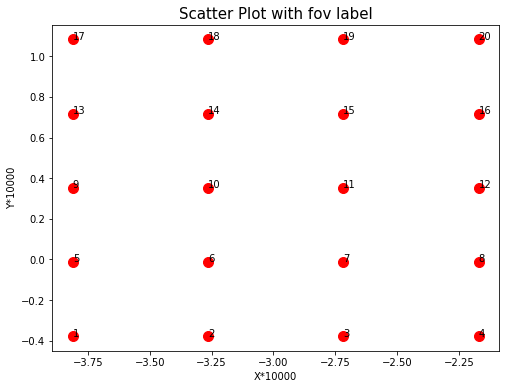

In [17]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(20)

X=np.random.randint(10, size=(5))
Y=np.random.randint(10, size=(5))

X = x_coordinate
Y = y_coordinate

annotations=["Point-1","Point-2","Point-3","Point-4","Point-5"]
annotations = list(fov_position["fov"])

plt.figure(figsize=(8,6))
plt.scatter(X,Y,s=100,color="red")
plt.xlabel("X*10000")
plt.ylabel("Y*10000")
plt.title("Scatter Plot with fov label",fontsize=15)
for i, label in enumerate(annotations):
    plt.annotate(label, (X[i], Y[i]))

plt.show()

# Image Data

In [14]:
def get_image_from_tif(tif_img,position=(None,None),radius=50):
  return tif_img[position[0]-radius:position[0]+radius, 
                 position[1]-radius:position[1]+radius, 
                 :]

In [15]:
img_path_2 = "../Lung13/Lung13-Flat_files_and_images/CellComposite/CellComposite_F002.jpg"
img2 = cv2.imread(img_path_2)
fig = plt.figure(figsize=(10,10))
plt.imshow(img2)

NameError: name 'cv2' is not defined

In [ ]:
import cv2
import matplotlib.colors as clr
import matplotlib.pyplot as plt

img_composite_path_1 = "Lung13/Lung13-Flat_files_and_images/CellComposite/CellComposite_F001.jpg"
img1_composite = cv2.imread(img_composite_path_1)
fig = plt.figure(figsize=(10,10))
plt.imshow(img1_composite)



In [ ]:
img_overlay_path_1 = "Lung13/Lung13-Flat_files_and_images/CellOverlay/CellOverlay_F001.jpg"
img1_overlay = cv2.imread(img_overlay_path_1)
fig = plt.figure(figsize=(10,10))
plt.imshow(img1_overlay)

In [ ]:
img1_overlay.shape

In [ ]:
cell_boundary_fov_1

In [ ]:
cell_boundary_fov_1[: 100]

In [22]:
# x = int(cell_boundary_fov_1.iloc[0]["CenterX_local_px"])
# y = int(cell_boundary_fov_1.iloc[0]["CenterY_local_px"])

In [23]:
red = [0, 0, 255]
# img1_overlay[y-10:y+10, x-10:x+10] = red
img1_overlay[17-10:17+10, 5244-10:5244+10] = red

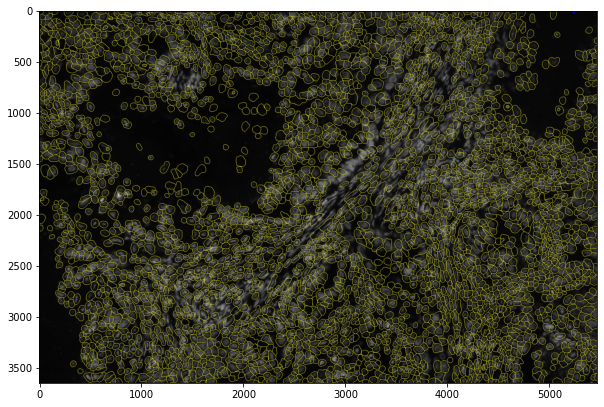

In [24]:
fig = plt.figure(figsize=(10,10))
plt.imshow(img1_overlay)

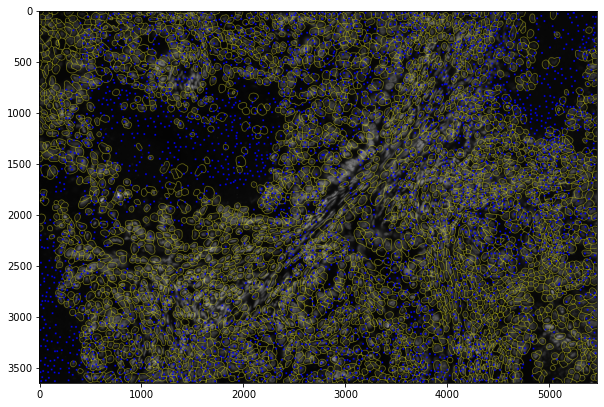

In [25]:
red = [0, 0, 255]
for i in range(len(cell_boundary_fov_1)):
    x = int(cell_boundary_fov_1.iloc[i]["CenterX_local_px"])
    y = int(cell_boundary_fov_1.iloc[i]["CenterY_local_px"])
    img1_overlay[y-8:y+8, x-8:x+8] = red
fig = plt.figure(figsize=(10,10))
plt.imshow(img1_overlay)

# Benchmark Generation

In [ ]:
"""
GeoMx: spot region area
1. mean: 37456.28 μm2
2. median: 24168.74 μm2
"""

In [ ]:
"""
CosMx: 
1. All FOVs are the same dimension, 5472 x 3648 pixels
2. multiply the pixel value by 0.18 um per pixel
3. FOV area: 5472 x 3648 pixels -> 984.96um x 656.64um = 646,764.134 um2 
"""

In [ ]:
"""
New Benchamrk from CosMx
1. length: 5472 pixels, width: 3648 pixels
2. simulated spot: 
    length: 5472 pixels / 5 = 1094.4 pixel = 196.992 um
    width: 3648 pixels / 4 = 912 pixel = 164.16 um
    one spot area: 196.992 um * 164.16 um = 32338.2067 um2
3. In total: 20 spots / FOV
"""

In [ ]:
"""
spot_fov_cellId_mapping.csv (spot_id, fov, cell_Id)

spot_gene_expression.csv (spot_id, gene1, gene2, gene3...)
"""

In [31]:
# fov_ids_lst = cell_boundary['fov'].unique()
# fov_ids_lst

In [32]:
# cell_boundary_fov_1 =  cell_boundary[(cell_boundary['fov']==fov_ids_lst[0])]
# cell_boundary_fov_1

In [33]:
# new_col_val = cell_boundary_fov_1.shape[0]* [0]
# cell_boundary_fov_1.insert(loc=0, column='spot_id', value=new_col_val)

In [34]:
# print(cell_boundary_fov_1.shape[0])
# cell_boundary_fov_1


In [35]:
"""
1094.4 pixel
912 pixel

(0-1094.4, 0-912)
"""

'\n1094.4 pixel\n912 pixel\n\n(0-1094.4, 0-912)\n'

In [36]:
# def get_fov_mapping(cell_boundary_fov_11):
#     new_col_val = cell_boundary_fov_11.shape[0]* [0]
#     cell_boundary_fov_11.insert(loc=0, column='spot_id', value=new_col_val)
    
#     for i in range(cell_boundary_fov_11.shape[0]):
#         one_row_sample = cell_boundary_fov_11.iloc[i]
#         if one_row_sample["CenterX_local_px"] <= 1094.4 * 1:
#             if one_row_sample["CenterY_local_px"] <= 912 * 1:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 1
#             elif one_row_sample["CenterY_local_px"] <= 912 * 2:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 2
#             elif one_row_sample["CenterY_local_px"] <= 912 * 3:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 3
#             elif one_row_sample["CenterY_local_px"] <= 912 * 4:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 4

#         elif one_row_sample["CenterX_local_px"] <= 1094.4 * 2:
#             if one_row_sample["CenterY_local_px"] <= 912 * 1:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 5
#             elif one_row_sample["CenterY_local_px"] <= 912 * 2:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 6
#             elif one_row_sample["CenterY_local_px"] <= 912 * 3:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 7
#             elif one_row_sample["CenterY_local_px"] <= 912 * 4:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 8

#         elif one_row_sample["CenterX_local_px"] <= 1094.4 * 3:
#             if one_row_sample["CenterY_local_px"] <= 912 * 1:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 9
#             elif one_row_sample["CenterY_local_px"] <= 912 * 2:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 10
#             elif one_row_sample["CenterY_local_px"] <= 912 * 3:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 11
#             elif one_row_sample["CenterY_local_px"] <= 912 * 4:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 12

#         elif one_row_sample["CenterX_local_px"] <= 1094.4 * 4:
#             if one_row_sample["CenterY_local_px"] <= 912 * 1:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 13
#             elif one_row_sample["CenterY_local_px"] <= 912 * 2:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 14
#             elif one_row_sample["CenterY_local_px"] <= 912 * 3:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 15
#             elif one_row_sample["CenterY_local_px"] <= 912 * 4:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 16

#         elif one_row_sample["CenterX_local_px"] <= 1094.4 * 5:
#             if one_row_sample["CenterY_local_px"] <= 912 * 1:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 17
#             elif one_row_sample["CenterY_local_px"] <= 912 * 2:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 18
#             elif one_row_sample["CenterY_local_px"] <= 912 * 3:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 19
#             elif one_row_sample["CenterY_local_px"] <= 912 * 4:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 20

#         else:
#             print("Wrong CenterX_local_px")
#     return cell_boundary_fov_11
    


In [18]:
# # cell_boundary, 82843 rows × 20 columns
# # fov_ids_lst: array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

# frames = []
# fov_ids_lst = cell_boundary['fov'].unique()
# for fov_id in fov_ids_lst:
#     fov_id = 1
#     print("fov_id:", fov_id)
#     cell_boundary_fov =  cell_boundary[(cell_boundary['fov']==fov_ids_lst[fov_id-1])]
#     print("cell_boundary_fov_without_spot_id:", cell_boundary_fov.shape)
#     cell_boundary_fov_with_spot_id = get_fov_mapping(cell_boundary_fov)
#     print("cell_boundary_fov_with_spot_id:", cell_boundary_fov_with_spot_id.shape)
# #     print(cell_boundary_fov_with_spot_id)
#     frames.append(cell_boundary_fov_with_spot_id)
#     break
# # result = pd.concat(frames)
# cell_boundary_fov_with_spot_id


fov_id: 1
cell_boundary_fov_without_spot_id: (3588, 20)
cell_boundary_fov_with_spot_id: (3588, 21)


spot_id  fov  cell_ID  Area  AspectRatio  CenterX_local_px  \
0           4    1        1  3703         1.69               290   
1           4    1        2  2383         2.88               609   
2           4    1        3  1937         2.09               806   
3           4    1        4  1551         1.18               983   
4           8    1        5  1895         1.50              1109   
...       ...  ...      ...   ...          ...               ...   
3583       17    1     3584  3782         1.88              5086   
3584        9    1     3585  2174         1.19              2610   
3585        9    1     3586  1085         1.28              2211   
3586        9    1     3587  1914         1.97              3202   
3587       17    1     3588  1359         1.88              5244   

      CenterY_local_px  CenterX_global_px  CenterY_global_px  Width  ...  \
0                 3622      -37826.666667        -150.222222     88  ...   
1                 3632      -37507.666667        -140.222222     92  ...   
2                 3631      -37310.666667        -141.222222     73  ...   
3                 3628      -37133.666667        -144.222222     47  ...   
4                 3629      -37007.666667        -143.222222     57  ...   
...                ...                ...                ...    ...  ...   
3583                27      -33030.666667       -3745.222222     96  ...   
3584                25      -35506.666667       -3747.222222     56  ...   
3585                17      -35905.666667       -3755.222222     41  ...   
3586                18      -34914.666667       -3754.222222     65  ...   
3587                17      -32872.666667       -3755.222222     60  ...   

      Mean.MembraneStain  Max.MembraneStain  Mean.PanCK  Max.PanCK  Mean.CD45  \
0                   2297               4545        4185      13854         49   
1                   3619               5831        6416      17592         35   
2                   2545               4550           0         35         22   
3                   5585              12901           0          0         50   
4                   4047              14116           0         76         25   
...                  ...                ...         ...        ...        ...   
3583                 498               3845          32       2305          3   
3584                 700               2524          54        428          2   
3585                2118               3908       10199      21867          0   
3586                 786               4200          37       1445          0   
3587                1939               3321         743       1578          0   

      Max.CD45  Mean.CD3  Max.CD3  Mean.DAPI  Max.DAPI  
0          865        77      391         38       372  
1         1059        45      826        114       531  
2          935         5      133        160       475  
3         1283       126      669        353       899  
4         1294       148      895        395       878  
...        ...       ...      ...        ...       ...  
3583       365         0        0        252       574  
3584       180        76     1874         77       299  
3585         0        14      323         98       488  
3586         0         0      141        137       466  
3587         0         0        0         67       503  

[3588 rows x 21 columns]

In [87]:
# data_result = data_result.append({'spot_id' : 2, 'fov' : 1, 'cell_ID' : 1}, ignore_index = True)
# data_result

## 1. spot_fov_cellId_mapping.csv

In [18]:
def get_spot_fov_cellId_mapping(data_result, cell_boundary_fov_11):
    new_col_val = cell_boundary_fov_11.shape[0]* [0]
    cell_boundary_fov_11.insert(loc=0, column='spot_id', value=new_col_val)

    for i in range(cell_boundary_fov_11.shape[0]):
        one_row_sample = cell_boundary_fov_11.iloc[i]
        if one_row_sample["CenterX_local_px"] <= 1094.4 * 1:
            if one_row_sample["CenterY_local_px"] <= 912 * 1:
                spot_id = 1
            elif one_row_sample["CenterY_local_px"] <= 912 * 2:
                spot_id = 2
            elif one_row_sample["CenterY_local_px"] <= 912 * 3:
                spot_id = 3
            elif one_row_sample["CenterY_local_px"] <= 912 * 4:
                spot_id = 4

        elif one_row_sample["CenterX_local_px"] <= 1094.4 * 2:
            if one_row_sample["CenterY_local_px"] <= 912 * 1:
                spot_id = 5
            elif one_row_sample["CenterY_local_px"] <= 912 * 2:
                spot_id = 6
            elif one_row_sample["CenterY_local_px"] <= 912 * 3:
                spot_id = 7
            elif one_row_sample["CenterY_local_px"] <= 912 * 4:
                spot_id = 8

        elif one_row_sample["CenterX_local_px"] <= 1094.4 * 3:
            if one_row_sample["CenterY_local_px"] <= 912 * 1:
                spot_id = 9
            elif one_row_sample["CenterY_local_px"] <= 912 * 2:
                spot_id = 10
            elif one_row_sample["CenterY_local_px"] <= 912 * 3:
                spot_id = 11
            elif one_row_sample["CenterY_local_px"] <= 912 * 4:
                spot_id = 12

        elif one_row_sample["CenterX_local_px"] <= 1094.4 * 4:
            if one_row_sample["CenterY_local_px"] <= 912 * 1:
                spot_id = 13
            elif one_row_sample["CenterY_local_px"] <= 912 * 2:
                spot_id = 14
            elif one_row_sample["CenterY_local_px"] <= 912 * 3:
                spot_id = 15
            elif one_row_sample["CenterY_local_px"] <= 912 * 4:
                spot_id = 16

        elif one_row_sample["CenterX_local_px"] <= 1094.4 * 5:
            if one_row_sample["CenterY_local_px"] <= 912 * 1:
                spot_id = 17
            elif one_row_sample["CenterY_local_px"] <= 912 * 2:
                spot_id = 18
            elif one_row_sample["CenterY_local_px"] <= 912 * 3:
                spot_id = 19
            elif one_row_sample["CenterY_local_px"] <= 912 * 4:
                spot_id = 20
        else:
            print("Wrong CenterX_local_px")
        data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)

    return data_result
        
        

In [19]:
data_final_result = pd.DataFrame(columns = ['spot_id', 'fov', 'cell_ID'])
data_final_result

Empty DataFrame
Columns: [spot_id, fov, cell_ID]
Index: []

In [20]:
cell_boundary

fov  cell_ID  Area  AspectRatio  CenterX_local_px  CenterY_local_px  \
0        1        1  3703         1.69               290              3622   
1        1        2  2383         2.88               609              3632   
2        1        3  1937         2.09               806              3631   
3        1        4  1551         1.18               983              3628   
4        1        5  1895         1.50              1109              3629   
...    ...      ...   ...          ...               ...               ...   
82838   20     4001  2829         2.75              2588                19   
82839   20     4002  1923         3.03              1219                16   
82840   20     4003  1156         2.12              2149                14   
82841   20     4004   839         2.33              4515                12   
82842   20     4005   682         1.70              4170                13   

       CenterX_global_px  CenterY_global_px  Width  Height  \
0          -37826.666667        -150.222222     88      52   
1          -37507.666667        -140.222222     92      32   
2          -37310.666667        -141.222222     73      35   
3          -37133.666667        -144.222222     47      40   
4          -37007.666667        -143.222222     57      38   
...                  ...                ...    ...     ...   
82838      -19112.000000       10846.777778     99      36   
82839      -20481.000000       10843.777778     91      30   
82840      -19551.000000       10841.777778     55      26   
82841      -17185.000000       10839.777778     49      21   
82842      -17530.000000       10840.777778     39      23   

       Mean.MembraneStain  Max.MembraneStain  Mean.PanCK  Max.PanCK  \
0                    2297               4545        4185      13854   
1                    3619               5831        6416      17592   
2                    2545               4550           0         35   
3                    5585              12901           0          0   
4                    4047              14116           0         76   
...                   ...                ...         ...        ...   
82838                5158              10180         634       2166   
82839                4000              15522          48       2460   
82840                6339               9804         211        570   
82841                3491               5600         203        481   
82842                3818               6387         211        444   

       Mean.CD45  Max.CD45  Mean.CD3  Max.CD3  Mean.DAPI  Max.DAPI  
0             49       865        77      391         38       372  
1             35      1059        45      826        114       531  
2             22       935         5      133        160       475  
3             50      1283       126      669        353       899  
4             25      1294       148      895        395       878  
...          ...       ...       ...      ...        ...       ...  
82838         41       304        39      304        888      2144  
82839        554      1593       162      780        536      2118  
82840        488      1269       233      583        704      1588  
82841        335       779       109      444        185       461  
82842        259       571        98      393        256       949  

[82843 rows x 20 columns]

In [21]:
type(cell_boundary)

pandas.core.frame.DataFrame

In [23]:
fov_ids_lst = cell_boundary['fov'].unique()
print("fov_ids_lst:", fov_ids_lst)


fov_ids_lst: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


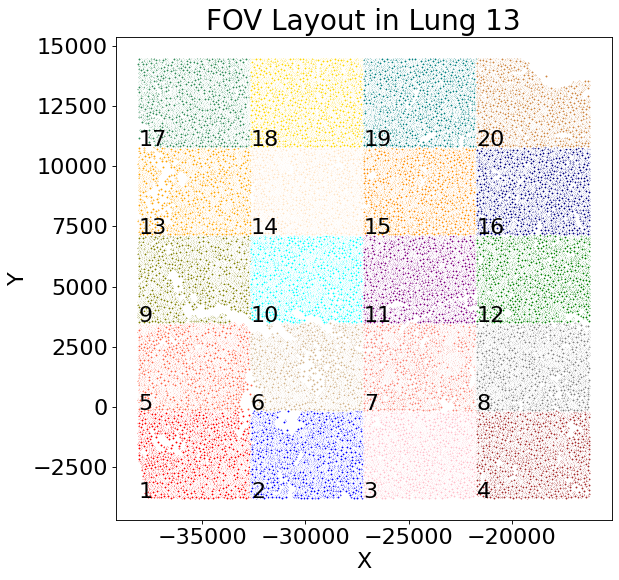

In [24]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8), dpi=80)

np.random.seed(20)
color = ["red", "blue", "pink", "brown", "tomato", "tan", "salmon", "gray", "olive", \
         "cyan", "purple", "green", "orange", "bisque", "darkorange", "navy", "seagreen", \
         "gold", "teal", "peru", "lightpink", "teal", "plum", "violet", "lavender", "khaki",\
        "red", "blue", "pink", "brown", "tomato", "tan", "salmon", "gray", "olive",\
        "cyan", "purple", "green", "orange", "bisque", "darkorange", "navy", "seagreen",\
        "gold", "teal", "peru", "lightpink", "teal", "plum", "violet", "lavender", "khaki",\
         "red", "blue", "pink", "brown", "tomato", "tan", "salmon", "gray", "olive", \
         "cyan", "purple", "green", "orange", "bisque", "darkorange", "navy", "seagreen", \
         "gold", "teal", "peru", "lightpink", "teal", "plum", "violet", "lavender", "khaki"
        ]
for i in range(len(fov_ids_lst)):
    fov_id = fov_ids_lst[i]
    X = cell_boundary[(cell_boundary['fov']==fov_id)]["CenterX_global_px"].tolist()
    Y = cell_boundary[(cell_boundary['fov']==fov_id)]["CenterY_global_px"].tolist()

    plt.scatter(X, Y, s=30, label = fov_id, c = color[i], marker='.', alpha = None, edgecolors= 'white')
#     plt.legend()

X = fov_position["x_global_px"].tolist()
Y = fov_position["y_global_px"].tolist()

X_plus = [i+ 5472 for i in X]
Y_plus = [i+3648 for i in Y]

annotations=["Point-1","Point-2","Point-3","Point-4","Point-5"]
annotations = (fov_position["fov"]).tolist()

# plt.scatter(X,Y,s=10,color="red")
# plt.scatter(X_plus, Y_plus,s=10,color="red")
# plt.scatter(X_plus, Y,s=10,color="red")
# plt.scatter(X, Y_plus,s=10,color="red")

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('X', fontsize=20)
plt.ylabel('Y', fontsize=20)
plt.title("FOV Layout in Lung 13",fontsize=25)
for i, label in enumerate(annotations):
    plt.annotate(label, (X[i], Y[i]), size=20)

plt.savefig("../../FOV_layout/Lung13.png", format="png", bbox_inches="tight")
plt.show()


In [22]:

for fov_id in fov_ids_lst:
    print("fov_id:", fov_id)
    cell_boundary_fov =  cell_boundary[(cell_boundary['fov']==fov_ids_lst[fov_id-1])]
    print("cell_boundary_fov_without_spot_id:", cell_boundary_fov.shape)
    data_final_result = get_spot_fov_cellId_mapping(data_final_result, cell_boundary_fov)

data_final_result

fov_ids_lst: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
fov_id: 1
cell_boundary_fov_without_spot_id: (3588, 20)


/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: Fu

/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: Fu

/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: Fu

/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: Fu

/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: Fu

/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: Fu

/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: Fu

/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: Fu

/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: Fu

/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: Fu

/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: Fu

/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: Fu

/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: Fu

/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: Fu

/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: Fu

/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: Fu

/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: Fu

/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: Fu

/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: Fu

/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: Fu

fov_id: 2
cell_boundary_fov_without_spot_id: (4213, 20)


/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: Fu

/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: Fu

/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: Fu

/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: Fu

/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: Fu

/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: Fu

/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: Fu

/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: Fu

/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
/tmp/ipykernel_5309/3461969010.py:58: Fu

KeyboardInterrupt: 

In [16]:
data_final_result_sample = data_final_result[(data_final_result['fov']==1)]
data_final_result_sample

Empty DataFrame
Columns: [spot_id, fov, cell_ID]
Index: []

In [17]:
data_final_result.to_csv('../Lung13/Lung13-Flat_files_and_images/new/spot_fov_cellId_mapping.csv')

In [18]:
data_final_result

Empty DataFrame
Columns: [spot_id, fov, cell_ID]
Index: []

## 2. spot_gene_expression.csv

In [19]:
data_final_result = pd.read_csv('../Lung13/Lung13-Flat_files_and_images/new/spot_fov_cellId_mapping.csv')
data_final_result

Empty DataFrame
Columns: [Unnamed: 0, spot_id, fov, cell_ID]
Index: []

In [17]:
gene_expression

fov  cell_ID  AATK  ABL1  ABL2  ACE  ACE2  ACKR1  ACKR3  ACKR4  ...  \
0        1        0    79   215   275  173   131    108    122    115  ...   
1        1        1     0     0     0    0     0      0      0      0  ...   
2        1        2     0     0     0    0     0      0      0      0  ...   
3        1        3     0     0     0    0     0      0      0      0  ...   
4        1        4     0     0     0    0     0      0      0      0  ...   
...    ...      ...   ...   ...   ...  ...   ...    ...    ...    ...  ...   
82858   20     4001     0     0     0    0     0      0      0      0  ...   
82859   20     4002     0     0     0    0     0      0      0      0  ...   
82860   20     4003     0     0     0    0     0      0      0      0  ...   
82861   20     4004     0     0     0    0     0      0      0      0  ...   
82862   20     4005     0     0     0    0     0      0      0      0  ...   

       NegPrb14  NegPrb15  NegPrb16  NegPrb17  NegPrb18  NegPrb19  NegPrb20  \
0           139        77       115       117       115       142       173   
1             0         0         0         0         0         0         0   
2             0         0         0         0         0         0         0   
3             0         0         0         0         0         0         0   
4             0         0         0         0         0         0         0   
...         ...       ...       ...       ...       ...       ...       ...   
82858         1         0         0         0         0         0         0   
82859         0         0         0         0         0         0         0   
82860         0         0         0         0         0         0         0   
82861         0         0         0         0         0         0         0   
82862         0         0         0         0         0         0         0   

       NegPrb21  NegPrb22  NegPrb23  
0           136       129       123  
1             0         0         0  
2             0         0         0  
3             0         0         0  
4             0         0         0  
...         ...       ...       ...  
82858         0         0         0  
82859         0         0         0  
82860         0         0         0  
82861         0         0         0  
82862         0         0         0  

[82863 rows x 982 columns]

In [18]:
fov_spot_cells_stats = pd.DataFrame(columns = ['fov', 'spot-id=1', 'spot-id=2', 'spot-id=3','spot-id=4', 'spot-id=5', 'spot-id=6', 'spot-id=7', 'spot-id=8', 'spot-id=9','spot-id=10', 'spot-id=11', 'spot-id=12', 'spot-id=13','spot-id=14', 'spot-id=15', 'spot-id=16', 'spot-id=17', 'spot-id=18', 'spot-id=19','spot-id=20'])
fov_spot_cells_stats


Empty DataFrame
Columns: [fov, spot-id=1, spot-id=2, spot-id=3, spot-id=4, spot-id=5, spot-id=6, spot-id=7, spot-id=8, spot-id=9, spot-id=10, spot-id=11, spot-id=12, spot-id=13, spot-id=14, spot-id=15, spot-id=16, spot-id=17, spot-id=18, spot-id=19, spot-id=20]
Index: []

[0 rows x 21 columns]

In [19]:
names = ['fov', 'spot-id=1', 'spot-id=2', 'spot-id=3','spot-id=4', 'spot-id=5', 'spot-id=6', 'spot-id=7', 'spot-id=8', 'spot-id=9','spot-id=10', 'spot-id=11', 'spot-id=12', 'spot-id=13','spot-id=14', 'spot-id=15', 'spot-id=16', 'spot-id=17', 'spot-id=18', 'spot-id=19','spot-id=20']
fov_dic = {}
for i in names:
    fov_dic[i] = 0
fov_dic



{'fov': 0,
 'spot-id=1': 0,
 'spot-id=2': 0,
 'spot-id=3': 0,
 'spot-id=4': 0,
 'spot-id=5': 0,
 'spot-id=6': 0,
 'spot-id=7': 0,
 'spot-id=8': 0,
 'spot-id=9': 0,
 'spot-id=10': 0,
 'spot-id=11': 0,
 'spot-id=12': 0,
 'spot-id=13': 0,
 'spot-id=14': 0,
 'spot-id=15': 0,
 'spot-id=16': 0,
 'spot-id=17': 0,
 'spot-id=18': 0,
 'spot-id=19': 0,
 'spot-id=20': 0}

In [20]:
fov_ids_lst = cell_boundary['fov'].unique()
spot_id_lst = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

for fov_id in fov_ids_lst:
    fov_data = data_final_result[(data_final_result['fov']==fov_id)]
    
    fov_dic_sample = fov_dic
    fov_dic_sample["fov"] = fov_id
    
    for i in spot_id_lst:
        spot_id_data = fov_data[(fov_data['spot_id']==i)]
        spot_id_num = "spot-id=" + str(i)
        fov_dic_sample[spot_id_num] = spot_id_data.shape[0]
    fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)



In [21]:
fov_spot_cells_stats.to_csv('../Lung13/Lung13-Flat_files_and_images/new/fov_new_spot_cell_stats.csv')
fov_spot_cells_stats

fov spot-id=1 spot-id=2 spot-id=3 spot-id=4 spot-id=5 spot-id=6 spot-id=7  \
0    1       147       132       110       192       206       193        45   
1    2       304       305       242       229       117       190       196   
2    3       208       156       191       154       148       199       178   
3    4       146       154       193       182       166       147       149   
4    5       312       237       177       254       260       250       249   
5    6       178       154       189       104       256       200       247   
6    7       171       198       174       290       230       271       209   
7    8       255       206       225       199       189       221       196   
8    9       245       287       258       171       204       103       142   
9   10       149       218       280       283       147       230       295   
10  11       216       252       253       330       178       276       198   
11  12       163       232       186       250       190       197       227   
12  13       133        69       191       106       117       119        55   
13  14       252       214       166       228       247       265       198   
14  15       220       240       211       229       230       262       211   
15  16       184       210       247       246       158       134       214   
16  17       135       183       193       231       242       223       183   
17  18       242       239       214       235       210       293       227   
18  19       268       262       267       257       248       249       242   
19  20       274       257       237       214       205       236       267   

   spot-id=8 spot-id=9  ... spot-id=11 spot-id=12 spot-id=13 spot-id=14  \
0        194       226  ...        161        188        241        207   
1         31       236  ...        206        151        180        298   
2        187       186  ...        192        243        212        193   
3        145       177  ...        175        218        152        163   
4        148       243  ...        222        228        267        234   
5        105       268  ...         66        131        219        113   
6        226       238  ...        171        121        108        243   
7        191       201  ...        227        163        117        177   
8        150        81  ...        212        233        123        284   
9        236       112  ...        295        269        138        150   
10       247       146  ...        254        248        211        178   
11       207       201  ...        241        128        189        168   
12       171       210  ...        240        268        317        324   
13       294       281  ...        216        207        297        244   
14       205       220  ...        187        256        265        216   
15       246       153  ...        220        209        158        165   
16       226       269  ...        228        226        215        251   
17       215       251  ...        316        252        285        285   
18       279       203  ...        179        236        224        178   
19       212       226  ...        251         75        216        256   

   spot-id=15 spot-id=16 spot-id=17 spot-id=18 spot-id=19 spot-id=20  
0         177        224        223        237        234         78  
1         261        210        156        155        249        289  
2         164        169        151        186        170        204  
3         192        175         77        169        136         98  
4         297        317         97        181        209        194  
5         151        118        270        268        203        181  
6         236        233        186        140        253        258  
7         300        152        154        167        240        142  
8         271        265        112        244        265        336  
9         267        212        202 

In [22]:
data_final_result[(data_final_result['fov']==fov_id)]

Unnamed: 0  spot_id   fov  cell_ID
78838       78838      4.0  20.0      1.0
78839       78839      4.0  20.0      2.0
78840       78840      4.0  20.0      3.0
78841       78841      4.0  20.0      4.0
78842       78842      4.0  20.0      5.0
...           ...      ...   ...      ...
82838       82838      9.0  20.0   4001.0
82839       82839      5.0  20.0   4002.0
82840       82840      5.0  20.0   4003.0
82841       82841     17.0  20.0   4004.0
82842       82842     13.0  20.0   4005.0

[4005 rows x 4 columns]

In [23]:
spot_gene_expression = ["fov", "spot_id"]
genes_name_lst = list(gene_expression.columns)[2:]
spot_gene_expression = spot_gene_expression + genes_name_lst
spot_gene_expression

['fov',
 'spot_id',
 'AATK',
 'ABL1',
 'ABL2',
 'ACE',
 'ACE2',
 'ACKR1',
 'ACKR3',
 'ACKR4',
 'ACTA2',
 'ACTG2',
 'ACVR1',
 'ACVR1B',
 'ACVR2A',
 'ACVRL1',
 'ADGRA2',
 'ADGRA3',
 'ADGRB2',
 'ADGRB3',
 'ADGRD1',
 'ADGRE1',
 'ADGRE2',
 'ADGRE5',
 'ADGRF1',
 'ADGRF3',
 'ADGRF4',
 'ADGRF5',
 'ADGRG1',
 'ADGRG2',
 'ADGRG3',
 'ADGRG5',
 'ADGRG6',
 'ADGRL1',
 'ADGRL2',
 'ADGRL4',
 'ADGRV1',
 'ADIPOQ',
 'ADIRF',
 'ADM2',
 'ADORA2A',
 'AGR2',
 'AHI1',
 'AHR',
 'AKT1',
 'ALCAM',
 'ANGPT1',
 'ANGPT2',
 'ANGPT4',
 'ANGPTL1',
 'ANXA1',
 'ANXA2',
 'ANXA4',
 'APOA1',
 'APOB',
 'APOD',
 'APP',
 'AQP3',
 'AR',
 'AREG',
 'ARF1',
 'ARG1',
 'ARHGDIB',
 'ARTN',
 'ATF3',
 'ATG10',
 'ATG12',
 'ATG5',
 'ATM',
 'ATR',
 'AXL',
 'AZGP1',
 'AZU1',
 'B2M',
 'B3GNT7',
 'BAG3',
 'BATF3',
 'BAX',
 'BCL2',
 'BCL2L1',
 'BECN1',
 'BEST1',
 'BGN',
 'BID',
 'BIRC5',
 'BMP1',
 'BMP2',
 'BMP3',
 'BMP4',
 'BMP5',
 'BMP6',
 'BMP7',
 'BMPR1A',
 'BMPR2',
 'BMX',
 'BRCA1',
 'BST1',
 'BST2',
 'BTG1',
 'BTK',
 'C11orf96',
 'C1QA'

In [24]:
spot_gene_expression = pd.DataFrame(columns = spot_gene_expression)
spot_gene_expression


Empty DataFrame
Columns: [fov, spot_id, AATK, ABL1, ABL2, ACE, ACE2, ACKR1, ACKR3, ACKR4, ACTA2, ACTG2, ACVR1, ACVR1B, ACVR2A, ACVRL1, ADGRA2, ADGRA3, ADGRB2, ADGRB3, ADGRD1, ADGRE1, ADGRE2, ADGRE5, ADGRF1, ADGRF3, ADGRF4, ADGRF5, ADGRG1, ADGRG2, ADGRG3, ADGRG5, ADGRG6, ADGRL1, ADGRL2, ADGRL4, ADGRV1, ADIPOQ, ADIRF, ADM2, ADORA2A, AGR2, AHI1, AHR, AKT1, ALCAM, ANGPT1, ANGPT2, ANGPT4, ANGPTL1, ANXA1, ANXA2, ANXA4, APOA1, APOB, APOD, APP, AQP3, AR, AREG, ARF1, ARG1, ARHGDIB, ARTN, ATF3, ATG10, ATG12, ATG5, ATM, ATR, AXL, AZGP1, AZU1, B2M, B3GNT7, BAG3, BATF3, BAX, BCL2, BCL2L1, BECN1, BEST1, BGN, BID, BIRC5, BMP1, BMP2, BMP3, BMP4, BMP5, BMP6, BMP7, BMPR1A, BMPR2, BMX, BRCA1, BST1, BST2, BTG1, BTK, ...]
Index: []

[0 rows x 982 columns]

In [25]:
def get_spot_gene_expression(spot_cell_mapping, fov_expression, spot_id):
    genes_lst = list(fov_expression.columns)[2:]
    
#     gene_count_dic = {}
#     for gene_name in genes_lst:
#         gene_count_dic[gene_name] = 0
    
    cell_id_lst = spot_cell_mapping[(spot_cell_mapping['spot_id']==spot_id)]["cell_ID"].tolist()
    
    cell_gene_expression_total = len(genes_lst)*[0]
    for cell_id in cell_id_lst:
        cell_gene_expression = fov_expression[(fov_expression['cell_ID'] == cell_id)]
        cell_gene_expression = cell_gene_expression.values.tolist()[0][2:]
        cell_gene_expression_total = np.sum([cell_gene_expression_total, cell_gene_expression], axis=0).tolist()
                
#         for gene_name in genes_lst:
#             gene_count_dic[gene_name] = gene_count_dic[gene_name] + cell_gene_expression[gene_name]
    
    return cell_gene_expression_total
    
    
    
        
    
    

In [26]:
fov_ids_lst = cell_boundary['fov'].unique()
spot_id_lst = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

for fov_id in fov_ids_lst:
    fov_data = data_final_result[(data_final_result['fov']==fov_id)]
    print("fov_id:", fov_id)
#     print("fov_data", fov_data)
    fov_gene_expression = gene_expression[(gene_expression['fov'] == fov_id)]
#     print("fov_gene_expression:", fov_gene_expression)
    
    for spot_id in spot_id_lst:
        to_append = [fov_id, spot_id]
        spot_gene_express = get_spot_gene_expression(fov_data, fov_gene_expression, spot_id)
        to_append = to_append + spot_gene_express
        a_series = pd.Series(to_append, index = spot_gene_expression.columns)
        spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
       
#     print(spot_gene_express, len(spot_gene_express))
    
    
    

fov_id: 1
fov_id: 2
fov_id: 3
fov_id: 4
fov_id: 5
fov_id: 6
fov_id: 7
fov_id: 8
fov_id: 9
fov_id: 10
fov_id: 11
fov_id: 12
fov_id: 13
fov_id: 14
fov_id: 15
fov_id: 16
fov_id: 17
fov_id: 18
fov_id: 19
fov_id: 20


In [27]:
spot_gene_expression

fov spot_id AATK ABL1 ABL2 ACE ACE2 ACKR1 ACKR3 ACKR4  ... NegPrb14  \
0     1       1    4   17   24  16   12    12     3     8  ...        7   
1     1       2    7   22   25  12   13    13     9     7  ...        8   
2     1       3    5    7   28  11   11     8     6     2  ...        7   
3     1       4    3   26   24   8   12     7     9    12  ...       10   
4     1       5   15   33   41  31   17    14    11     8  ...       15   
..   ..     ...  ...  ...  ...  ..  ...   ...   ...   ...  ...      ...   
395  20      16    0    0    0   0    0     0     0     0  ...        0   
396  20      17    2   10   14  11    8     0     3     3  ...        5   
397  20      18    7   17   26  13   13    10    10     9  ...       14   
398  20      19    6    9   10   3    1     1     4     4  ...        7   
399  20      20    0    0    0   0    0     0     0     0  ...        0   

    NegPrb15 NegPrb16 NegPrb17 NegPrb18 NegPrb19 NegPrb20 NegPrb21 NegPrb22  \
0          8        8       14        8        5       11       11       13   
1          6        6       11        6       15       22        4        9   
2          3       14        5        3        9        7        8        4   
3         10        9       14        5        9        9       10        6   
4         12        9       25       12       17       17       10       13   
..       ...      ...      ...      ...      ...      ...      ...      ...   
395        0        0        0        0        0        0        0        0   
396        2        7        3        4        3        5        0        5   
397        8       11       12       11        6       14        5       10   
398        2        0        0        1        2        3        1        1   
399        0        0        0        0        0        0        0        0   

    NegPrb23  
0          5  
1          2  
2          6  
3          7  
4          9  
..       ...  
395        0  
396        0  
397       11  
398        0  
399        0  

[400 rows x 982 columns]

In [20]:
spot_gene_expression.to_csv('../Lung13/Lung13-Flat_files_and_images/new/spot_gene_expression.csv')

NameError: name 'spot_gene_expression' is not defined

## 3. Ground Truth

In [14]:
CosMx_cell_type = pd.read_csv('../cosMX_showcase_meta.csv')
CosMx_cell_type

Unnamed: 0      cell_ID  fov  Area  AspectRatio  Width  Height  \
0                1      c_1_1_1    1  1259         1.34     47      35   
1                2      c_1_1_2    1  3723         1.45     87      60   
2                3      c_1_1_3    1  2010         1.62     68      42   
3                4      c_1_1_4    1  3358         0.47     48     102   
4                5      c_1_1_5    1  1213         1.00     38      38   
...            ...          ...  ...   ...          ...    ...     ...   
771231      771232  c_8_20_3999   20  1314         1.02     45      44   
771232      771233  c_8_20_4000   20  1549         1.71     60      35   
771233      771234  c_8_20_4001   20  2829         2.75     99      36   
771234      771235  c_8_20_4003   20  1156         2.12     55      26   
771235      771236  c_8_20_4004   20   839         2.33     49      21   

        Mean.CD298  Max.CD298  Mean.G  ...  Panel  Diversity  totalcounts  \
0             3473       7354     715  ...   980p         19           23   
1             3895      13832   18374  ...   980p         23           26   
2             2892       6048    3265  ...   980p         51           74   
3             6189      16091     485  ...   980p         48           60   
4             8138      19281     549  ...   980p         39           52   
...            ...        ...     ...  ...    ...        ...          ...   
771231        7430       9572     370  ...   980p         87          135   
771232        8362      11209     161  ...   980p         60           74   
771233        5158      10180     634  ...   980p         69          102   
771234        6339       9804     211  ...   980p         30           31   
771235        3491       5600     203  ...   980p         42           69   

        log10totalcounts  background  remove_flagged_cells  patient  \
0               1.361728    0.004956                 False    Lung5   
1               1.414973    0.005603                 False    Lung5   
2               1.869232    0.015946                 False    Lung5   
3               1.778151    0.012929                 False    Lung5   
4               1.716003    0.011205                 False    Lung5   
...                  ...         ...                   ...      ...   
771231          2.130334    0.029091                 False   Lung13   
771232          1.869232    0.015946                 False   Lung13   
771233          2.008600    0.021980                 False   Lung13   
771234          1.491362    0.006680                 False   Lung13   
771235          1.838849    0.014869                 False   Lung13   

           cell_type                        niche prop_tumor_in_100_neighbors  
0                mDC  plasmablast-enriched stroma                        0.09  
1        endothelial                       stroma                        0.00  
2        endothelial                       stroma                        0.01  
3                pDC                       stroma                        0.00  
4         macrophage                       stroma                        0.00  
...              ...                          ...                         ...  
771231  T CD4 memory                       immune                        0.34  
771232  T CD4 memory                       immune                        0.30  
771233    macrophage                  macrophages                        0.41  
771234  T CD4 memory                  macrophages                        0.11  
771235    macrophage                       immune                        0.16  

[771236 rows x 35 columns]

In [15]:
# CosMx_cell_type.columns.values[0] = "sample_id"
# CosMx_cell_type
CosMx_cell_type_sample_8 = CosMx_cell_type.iloc[sample_8_index_lst]
CosMx_cell_type_sample_8

Unnamed: 0      cell_ID  fov  Area  AspectRatio  Width  Height  \
690000      690001      c_8_1_1    1  3703         1.69     88      52   
690001      690002      c_8_1_2    1  2383         2.88     92      32   
690002      690003      c_8_1_3    1  1937         2.09     73      35   
690003      690004      c_8_1_5    1  1895         1.50     57      38   
690004      690005      c_8_1_6    1  2986         2.42     92      38   
...            ...          ...  ...   ...          ...    ...     ...   
771231      771232  c_8_20_3999   20  1314         1.02     45      44   
771232      771233  c_8_20_4000   20  1549         1.71     60      35   
771233      771234  c_8_20_4001   20  2829         2.75     99      36   
771234      771235  c_8_20_4003   20  1156         2.12     55      26   
771235      771236  c_8_20_4004   20   839         2.33     49      21   

        Mean.CD298  Max.CD298  Mean.G  ...  Panel  Diversity  totalcounts  \
690000        2297       4545    4185  ...   980p         65           98   
690001        3619       5831    6416  ...   980p         74           96   
690002        2545       4550       0  ...   980p         55           88   
690003        4047      14116       0  ...   980p         35           50   
690004        2373       7298       0  ...   980p         77          131   
...            ...        ...     ...  ...    ...        ...          ...   
771231        7430       9572     370  ...   980p         87          135   
771232        8362      11209     161  ...   980p         60           74   
771233        5158      10180     634  ...   980p         69          102   
771234        6339       9804     211  ...   980p         30           31   
771235        3491       5600     203  ...   980p         42           69   

        log10totalcounts  background  remove_flagged_cells  patient  \
690000          1.991226    0.021118                 False   Lung13   
690001          1.982271    0.020687                 False   Lung13   
690002          1.944483    0.018963                 False   Lung13   
690003          1.698970    0.010774                 False   Lung13   
690004          2.117271    0.028229                 False   Lung13   
...                  ...         ...                   ...      ...   
771231          2.130334    0.029091                 False   Lung13   
771232          1.869232    0.015946                 False   Lung13   
771233          2.008600    0.021980                 False   Lung13   
771234          1.491362    0.006680                 False   Lung13   
771235          1.838849    0.014869                 False   Lung13   

           cell_type        niche prop_tumor_in_100_neighbors  
690000      tumor 13       immune                        0.46  
690001      tumor 13       immune                        0.38  
690002    fibroblast       immune                        0.22  
690003    fibroblast       immune                        0.20  
690004    fibroblast       immune                        0.20  
...              ...          ...                         ...  
771231  T CD4 memory       immune                        0.34  
771232  T CD4 memory       immune                        0.30  
771233    macrophage  macrophages                        0.41  
771234  T CD4 memory  macrophages                        0.11  
771235    macrophage       immune                        0.16  

[81236 rows x 35 columns]

In [16]:
CosMx_cell_type_sample_8.reset_index(drop=True, inplace=True)
CosMx_cell_type_sample_8

Unnamed: 0      cell_ID  fov  Area  AspectRatio  Width  Height  \
0          690001      c_8_1_1    1  3703         1.69     88      52   
1          690002      c_8_1_2    1  2383         2.88     92      32   
2          690003      c_8_1_3    1  1937         2.09     73      35   
3          690004      c_8_1_5    1  1895         1.50     57      38   
4          690005      c_8_1_6    1  2986         2.42     92      38   
...           ...          ...  ...   ...          ...    ...     ...   
81231      771232  c_8_20_3999   20  1314         1.02     45      44   
81232      771233  c_8_20_4000   20  1549         1.71     60      35   
81233      771234  c_8_20_4001   20  2829         2.75     99      36   
81234      771235  c_8_20_4003   20  1156         2.12     55      26   
81235      771236  c_8_20_4004   20   839         2.33     49      21   

       Mean.CD298  Max.CD298  Mean.G  ...  Panel  Diversity  totalcounts  \
0            2297       4545    4185  ...   980p         65           98   
1            3619       5831    6416  ...   980p         74           96   
2            2545       4550       0  ...   980p         55           88   
3            4047      14116       0  ...   980p         35           50   
4            2373       7298       0  ...   980p         77          131   
...           ...        ...     ...  ...    ...        ...          ...   
81231        7430       9572     370  ...   980p         87          135   
81232        8362      11209     161  ...   980p         60           74   
81233        5158      10180     634  ...   980p         69          102   
81234        6339       9804     211  ...   980p         30           31   
81235        3491       5600     203  ...   980p         42           69   

       log10totalcounts  background  remove_flagged_cells  patient  \
0              1.991226    0.021118                 False   Lung13   
1              1.982271    0.020687                 False   Lung13   
2              1.944483    0.018963                 False   Lung13   
3              1.698970    0.010774                 False   Lung13   
4              2.117271    0.028229                 False   Lung13   
...                 ...         ...                   ...      ...   
81231          2.130334    0.029091                 False   Lung13   
81232          1.869232    0.015946                 False   Lung13   
81233          2.008600    0.021980                 False   Lung13   
81234          1.491362    0.006680                 False   Lung13   
81235          1.838849    0.014869                 False   Lung13   

          cell_type        niche prop_tumor_in_100_neighbors  
0          tumor 13       immune                        0.46  
1          tumor 13       immune                        0.38  
2        fibroblast       immune                        0.22  
3        fibroblast       immune                        0.20  
4        fibroblast       immune                        0.20  
...             ...          ...                         ...  
81231  T CD4 memory       immune                        0.34  
81232  T CD4 memory       immune                        0.30  
81233    macrophage  macrophages                        0.41  
81234  T CD4 memory  macrophages                        0.11  
81235    macrophage       immune                        0.16  

[81236 rows x 35 columns]

In [17]:

for i in CosMx_cell_type_sample_8.index:
#     print(i)
    
#     sample_id = int(CosMx_cell_type.iloc[i]["cell_ID"].split("_")[1])
#     fov_id = int(CosMx_cell_type.iloc[i]["cell_ID"].split("_")[2])
#     cell_id = int(CosMx_cell_type.iloc[i]["cell_ID"].split("_")[3])

#     CosMx_cell_type_sample_8.at[i,'sample_id']= int(CosMx_cell_type_sample_8.iloc[i]["cell_ID"].split("_")[1])
    CosMx_cell_type_sample_8.at[i,'cell_ID']= int(CosMx_cell_type_sample_8.iloc[i]["cell_ID"].split("_")[3])

CosMx_cell_type_sample_8


Unnamed: 0 cell_ID  fov  Area  AspectRatio  Width  Height  Mean.CD298  \
0          690001       1    1  3703         1.69     88      52        2297   
1          690002       2    1  2383         2.88     92      32        3619   
2          690003       3    1  1937         2.09     73      35        2545   
3          690004       5    1  1895         1.50     57      38        4047   
4          690005       6    1  2986         2.42     92      38        2373   
...           ...     ...  ...   ...          ...    ...     ...         ...   
81231      771232    3999   20  1314         1.02     45      44        7430   
81232      771233    4000   20  1549         1.71     60      35        8362   
81233      771234    4001   20  2829         2.75     99      36        5158   
81234      771235    4003   20  1156         2.12     55      26        6339   
81235      771236    4004   20   839         2.33     49      21        3491   

       Max.CD298  Mean.G  ...  Panel  Diversity  totalcounts  \
0           4545    4185  ...   980p         65           98   
1           5831    6416  ...   980p         74           96   
2           4550       0  ...   980p         55           88   
3          14116       0  ...   980p         35           50   
4           7298       0  ...   980p         77          131   
...          ...     ...  ...    ...        ...          ...   
81231       9572     370  ...   980p         87          135   
81232      11209     161  ...   980p         60           74   
81233      10180     634  ...   980p         69          102   
81234       9804     211  ...   980p         30           31   
81235       5600     203  ...   980p         42           69   

       log10totalcounts  background  remove_flagged_cells  patient  \
0              1.991226    0.021118                 False   Lung13   
1              1.982271    0.020687                 False   Lung13   
2              1.944483    0.018963                 False   Lung13   
3              1.698970    0.010774                 False   Lung13   
4              2.117271    0.028229                 False   Lung13   
...                 ...         ...                   ...      ...   
81231          2.130334    0.029091                 False   Lung13   
81232          1.869232    0.015946                 False   Lung13   
81233          2.008600    0.021980                 False   Lung13   
81234          1.491362    0.006680                 False   Lung13   
81235          1.838849    0.014869                 False   Lung13   

          cell_type        niche prop_tumor_in_100_neighbors  
0          tumor 13       immune                        0.46  
1          tumor 13       immune                        0.38  
2        fibroblast       immune                        0.22  
3        fibroblast       immune                        0.20  
4        fibroblast       immune                        0.20  
...             ...          ...                         ...  
81231  T CD4 memory       immune                        0.34  
81232  T CD4 memory       immune                        0.30  
81233    macrophage  macrophages                        0.41  
81234  T CD4 memory  macrophages                        0.11  
81235    macrophage       immune                        0.16  

[81236 rows x 35 columns]

In [27]:
sample_8_dic = {}
for key in CosMx_cell_type_sample_8["cell_type"].tolist():
    if key not in sample_8_dic:
        sample_8_dic[key] = 1
    else:
        sample_8_dic[key] = sample_8_dic[key] + 1

sample_8_dic


{'tumor 13': 26030,
 'fibroblast': 13609,
 'macrophage': 17989,
 'T CD4 memory': 9344,
 'T CD8 memory': 3067,
 'plasmablast': 1638,
 'B-cell': 70,
 'mast': 1487,
 'Treg': 2244,
 'endothelial': 1449,
 'pDC': 2702,
 'T CD4 naive': 62,
 'neutrophil': 412,
 'T CD8 naive': 184,
 'NK': 105,
 'monocyte': 93,
 'tumor 9': 170,
 'tumor 12': 62,
 'epithelial': 132,
 'mDC': 338,
 'tumor 5': 23,
 'tumor 6': 26}

In [18]:
CosMx_cell_type_sample_8_fov_1 = CosMx_cell_type_sample_8[(CosMx_cell_type_sample_8['fov']==1)]
CosMx_cell_type_sample_8_fov_1

Unnamed: 0 cell_ID  fov  Area  AspectRatio  Width  Height  Mean.CD298  \
0         690001       1    1  3703         1.69     88      52        2297   
1         690002       2    1  2383         2.88     92      32        3619   
2         690003       3    1  1937         2.09     73      35        2545   
3         690004       5    1  1895         1.50     57      38        4047   
4         690005       6    1  2986         2.42     92      38        2373   
...          ...     ...  ...   ...          ...    ...     ...         ...   
3533      693534    3583    1  1682         1.06     55      52        1636   
3534      693535    3584    1  3782         1.88     96      51         498   
3535      693536    3585    1  2174         1.19     56      47         700   
3536      693537    3586    1  1085         1.28     41      32        2118   
3537      693538    3587    1  1914         1.97     65      33         786   

      Max.CD298  Mean.G  ...  Panel  Diversity  totalcounts  log10totalcounts  \
0          4545    4185  ...   980p         65           98          1.991226   
1          5831    6416  ...   980p         74           96          1.982271   
2          4550       0  ...   980p         55           88          1.944483   
3         14116       0  ...   980p         35           50          1.698970   
4          7298       0  ...   980p         77          131          2.117271   
...         ...     ...  ...    ...        ...          ...               ...   
3533       5433     322  ...   980p        103          253          2.403121   
3534       3845      32  ...   980p         29           31          1.491362   
3535       2524      54  ...   980p         59          102          2.008600   
3536       3908   10199  ...   980p         71          115          2.060698   
3537       4200      37  ...   980p         91          182          2.260071   

      background  remove_flagged_cells  patient     cell_type  \
0       0.021118                 False   Lung13      tumor 13   
1       0.020687                 False   Lung13      tumor 13   
2       0.018963                 False   Lung13    fibroblast   
3       0.010774                 False   Lung13    fibroblast   
4       0.028229                 False   Lung13    fibroblast   
...          ...                   ...      ...           ...   
3533    0.054518                 False   Lung13    macrophage   
3534    0.006680                 False   Lung13  T CD4 memory   
3535    0.021980                 False   Lung13    macrophage   
3536    0.024781                 False   Lung13      tumor 13   
3537    0.039219                 False   Lung13    macrophage   

                      niche prop_tumor_in_100_neighbors  
0                    immune                        0.46  
1                    immune                        0.38  
2                    immune                        0.22  
3                    immune                        0.20  
4                    immune                        0.20  
...                     ...                         ...  
3533            macrophages                        0.07  
3534                 immune                        0.30  
3535            macrophages                        0.20  
3536  tumor-stroma boundary                        0.56  
3537            macrophages                        0.08  

[3538 rows x 35 columns]

In [14]:
cell_type_lst = list(CosMx_cell_type_sample_8['cell_type'].unique())
print(len(cell_type_lst))
cell_type_lst

22


['tumor 13',
 'fibroblast',
 'macrophage',
 'T CD4 memory',
 'T CD8 memory',
 'plasmablast',
 'B-cell',
 'mast',
 'Treg',
 'endothelial',
 'pDC',
 'T CD4 naive',
 'neutrophil',
 'T CD8 naive',
 'NK',
 'monocyte',
 'tumor 9',
 'tumor 12',
 'epithelial',
 'mDC',
 'tumor 5',
 'tumor 6']

In [62]:
# list(CosMx_cell_type.columns)
column_name_lst = ['fov', 'spot_id'] + cell_type_lst
ground_truth_table = pd.DataFrame(columns = column_name_lst)
ground_truth_table


Empty DataFrame
Columns: [fov, spot_id, tumor 13, fibroblast, macrophage, T CD4 memory, T CD8 memory, plasmablast, B-cell, mast, Treg, endothelial, pDC, T CD4 naive, neutrophil, T CD8 naive, NK, monocyte, tumor 9, tumor 12, epithelial, mDC, tumor 5, tumor 6]
Index: []

[0 rows x 24 columns]

In [63]:
spot_celld_mapping = pd.read_csv('../Lung13/Lung13-Flat_files_and_images/new/spot_fov_cellId_mapping.csv')
spot_celld_mapping

Unnamed: 0  spot_id   fov  cell_ID
0               0      4.0   1.0      1.0
1               1      4.0   1.0      2.0
2               2      4.0   1.0      3.0
3               3      4.0   1.0      4.0
4               4      8.0   1.0      5.0
...           ...      ...   ...      ...
82838       82838      9.0  20.0   4001.0
82839       82839      5.0  20.0   4002.0
82840       82840      5.0  20.0   4003.0
82841       82841     17.0  20.0   4004.0
82842       82842     13.0  20.0   4005.0

[82843 rows x 4 columns]

In [64]:
cell_id_lst = CosMx_cell_type_sample_8["cell_ID"].tolist()
len(cell_id_lst)

81236

In [65]:
def get_spot_cell_type_dic(one_spot_cell_lst, CosMx_cell_type, cell_type_dic):
    existig_cell_ids_with_celltype = CosMx_cell_type['cell_ID'].unique()
    
#     import ipdb
#     ipdb.set_trace()

    for cell_id in one_spot_cell_lst:
        
        if cell_id in existig_cell_ids_with_celltype:
            one_cell_sample = CosMx_cell_type[(CosMx_cell_type['cell_ID']==cell_id)]
            cell_type = one_cell_sample["cell_type"].values[0]
            cell_type_dic[cell_type] = cell_type_dic[cell_type] + 1
        else:
            print("cell id not found in groud truth!!!")
        
    return cell_type_dic
        


In [ ]:
fov_ids_lst = spot_celld_mapping['fov'].unique()
spot_id_lst = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

for fov_id in fov_ids_lst:
    fov_data = spot_celld_mapping[(spot_celld_mapping['fov']==fov_id)]
    
    for spot_id in spot_id_lst:
        sample_dic = {}
        for i in column_name_lst:
            sample_dic[i] = 0
        
        print("fov_id:", fov_id, "spot_id:", spot_id)
        
        spot_id_data = fov_data[(fov_data['spot_id']==spot_id)]
        one_spot_cell_lst = list(spot_id_data['cell_ID'].unique())
        
        CosMx_cell_type_sample_fov = CosMx_cell_type_sample_8[(CosMx_cell_type_sample_8['fov']==fov_id)]
        sample_dic = get_spot_cell_type_dic(one_spot_cell_lst, CosMx_cell_type_sample_fov, sample_dic)
        
        sample_dic["fov"] = fov_id
        sample_dic["spot_id"] = spot_id
        ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)


        
#         print(fov_id, spot_id, len(one_spot_cell_lst))

        
ground_truth_table


fov_id: 1.0 spot_id: 1
cell id not found in groud truth!!!
fov_id: 1.0 spot_id: 2
cell id not found in groud truth!!!
cell id not found in groud truth!!!
fov_id: 1.0 spot_id: 3
cell id not found in groud truth!!!
cell id not found in groud truth!!!
fov_id: 1.0 spot_id: 4
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
fov_id: 1.0 spot_id: 5
fov_id: 1.0 spot_id: 6
fov_id: 1.0 spot_id: 7
cell id not found in groud truth!!!
fov_id: 1.0 spot_id: 8
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
fov_id: 1.0 spot_id: 9
cell id not found in groud truth!!!
fov_id: 1.0 spot_id: 10
fov_id: 1.0 spot_id: 11
fov_id: 1.0 spot_id: 12
cell id not found in groud truth!!!
fov_id: 1.0 spot_id: 13
fov_id: 1.0 spot_id: 14
fov_id: 1.0 spot_id: 15
cell id not found in groud truth!!!
fov_id: 1.0 spot_id: 16
cell id not found in groud truth!!!
cell id not found in groud truth!!!
fov_id: 1.0 s

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
fov_id: 4.0 spot_id: 13
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
fov_id: 4.0 spot_id: 14
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
fov_id: 4.0 spot_id: 15
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
fov_id: 6.0 spot_id: 4
cell id not found in groud truth!!!
cell id not found in groud truth!!!
fov_id: 6.0 spot_id: 5
cell id not found in groud truth!!!
fov_id: 6.0 spot_id: 6
fov_id: 6.0 spot_id: 7
fov_id: 6.0 spot_id: 8
cell id not found in groud truth!!!
fov_id: 6.0 spot_id: 9
cell id not found in groud truth!!!
fov_id: 6.0 spot_id: 10
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
fov_id: 6.0 spot_id: 11
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in g

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
fov_id: 7.0 spot_id: 6
cell id not found in groud truth!!!
cell id not found in groud truth!!!
fov_id: 7.0 spot_id: 7
cell id not found in groud truth!!!
fov_id: 7.0 spot_id: 8
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
fov_id: 7.0 spot_id: 9
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
fov_id: 7.0 spot_id: 10
cell id not found in groud truth!!!
cell id not found in

fov_id: 9.0 spot_id: 8
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
fov_id: 9.0 spot_id: 9
cell id not found in groud truth!!!
cell id not found in groud truth!!!
fov_id: 9.0 spot_id: 10
cell id not found in groud truth!!!
cell id not found in groud truth!!!
fov_id: 9.0 spot_id: 11
cell id not found in groud truth!!!
fov_id: 9.0 spot_id: 12
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
fov_id: 9.0 spot_id: 13
cell id not found in groud truth!!!
cell id not found in groud truth!!!
fov_id: 9.0 spot_id: 14
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
fov_id: 9.0 spot_id: 15
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
fov_id: 9.0 spot_id: 16
fov_id: 9.0 spot_id: 17
cell id not found in groud truth!!!
cell i

fov_id: 12.0 spot_id: 17
cell id not found in groud truth!!!
cell id not found in groud truth!!!
fov_id: 12.0 spot_id: 18
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
fov_id: 12.0 spot_id: 19
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
fov_id: 12.0 spot_id: 20
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
fov_id: 13.0 spot_id: 1
cell id not 

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
fov_id: 16.0 spot_id: 2
cell id not found in groud truth!!!
fov_id: 16.0 spot_id: 3
cell id not found in groud truth!!!
fov_id: 16.0 spot_id: 4
cell id not found in groud truth!!!
fov_id: 16.0 spot_id: 5
cell id not found in groud truth!!!
fov_id: 16.0 spot_id: 6
fov_id: 16.0 spot_id: 7
fov_id: 16.0 spot_id: 8
cell id not found in groud truth!!!
cell id not found in groud truth!!!
fov_id: 16.0 spot_id: 9
cell id not found in groud truth!!!
cell id not found in groud truth!!!
fov_id: 16.0 spot_id: 10
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud 

In [60]:
ground_truth_table

fov  spot_id  tumor 13  fibroblast  macrophage  T CD4 memory  \
0     1.0      1.0      49.0        24.0        48.0           5.0   
1     1.0      2.0      84.0        42.0       107.0          10.0   
2     1.0      3.0     107.0        64.0       148.0          18.0   
3     1.0      4.0     185.0        94.0       210.0          28.0   
4     1.0      5.0     263.0       140.0       216.0          58.0   
..    ...      ...       ...         ...         ...           ...   
395  20.0     16.0    1075.0       508.0       653.0         493.0   
396  20.0     17.0    1105.0       548.0       701.0         519.0   
397  20.0     18.0    1217.0       585.0       741.0         549.0   
398  20.0     19.0    1243.0       618.0       771.0         562.0   
399  20.0     20.0    1243.0       618.0       771.0         562.0   

     T CD8 memory  plasmablast  B-cell  mast  ...  neutrophil  T CD8 naive  \
0             4.0          3.0     0.0   1.0  ...         4.0          0.0   
1             7.0          3.0     0.0   2.0  ...         9.0          0.0   
2             8.0          3.0     0.0   2.0  ...        18.0          0.0   
3            11.0          4.0     1.0   2.0  ...        20.0          1.0   
4            12.0         18.0     1.0  15.0  ...        20.0          1.0   
..            ...          ...     ...   ...  ...         ...          ...   
395         165.0         40.0     2.0  58.0  ...         1.0          6.0   
396         169.0         47.0     2.0  65.0  ...         1.0          6.0   
397         179.0         52.0     2.0  69.0  ...         1.0          6.0   
398         185.0         62.0     2.0  74.0  ...         1.0          6.0   
399         185.0         62.0     2.0  74.0  ...         1.0          6.0   

      NK  monocyte  tumor 9  tumor 12  epithelial   mDC  tumor 5  tumor 6  
0    0.0       0.0      0.0       0.0         0.0   0.0      0.0      0.0  
1    0.0       0.0      2.0       0.0         0.0   0.0      1.0      0.0  
2    0.0       0.0      2.0       1.0         0.0   0.0      1.0      0.0  
3    0.0       1.0      2.0       1.0         0.0   0.0      1.0      0.0  
4    1.0       1.0      2.0       1.0         0.0   0.0      1.0      0.0  
..   ...       ...      ...       ...         ...   ...      ...      ...  
395  2.0       4.0      0.0       0.0         5.0  45.0      1.0      3.0  
396  2.0       5.0      0.0       0.0         5.0  49.0      1.0      3.0  
397  3.0       5.0      0.0       1.0         5.0  58.0      1.0      3.0  
398  3.0       5.0      1.0       1.0         6.0  62.0      1.0      3.0  
399  3.0       5.0      1.0       1.0         6.0  62.0      1.0      3.0  

[400 rows x 24 columns]

In [61]:
ground_truth_table.to_csv('../Lung13/Lung13-Flat_files_and_images/new/ground_truth.csv')

## mapping between sample and real sample

In [9]:
CosMx_cell_type = pd.read_csv('../cosMX_showcase_meta.csv')
CosMx_cell_type

Unnamed: 0      cell_ID  fov  Area  AspectRatio  Width  Height  \
0                1      c_1_1_1    1  1259         1.34     47      35   
1                2      c_1_1_2    1  3723         1.45     87      60   
2                3      c_1_1_3    1  2010         1.62     68      42   
3                4      c_1_1_4    1  3358         0.47     48     102   
4                5      c_1_1_5    1  1213         1.00     38      38   
...            ...          ...  ...   ...          ...    ...     ...   
771231      771232  c_8_20_3999   20  1314         1.02     45      44   
771232      771233  c_8_20_4000   20  1549         1.71     60      35   
771233      771234  c_8_20_4001   20  2829         2.75     99      36   
771234      771235  c_8_20_4003   20  1156         2.12     55      26   
771235      771236  c_8_20_4004   20   839         2.33     49      21   

        Mean.CD298  Max.CD298  Mean.G  ...  Panel  Diversity  totalcounts  \
0             3473       7354     715  ...   980p         19           23   
1             3895      13832   18374  ...   980p         23           26   
2             2892       6048    3265  ...   980p         51           74   
3             6189      16091     485  ...   980p         48           60   
4             8138      19281     549  ...   980p         39           52   
...            ...        ...     ...  ...    ...        ...          ...   
771231        7430       9572     370  ...   980p         87          135   
771232        8362      11209     161  ...   980p         60           74   
771233        5158      10180     634  ...   980p         69          102   
771234        6339       9804     211  ...   980p         30           31   
771235        3491       5600     203  ...   980p         42           69   

        log10totalcounts  background  remove_flagged_cells  patient  \
0               1.361728    0.004956                 False    Lung5   
1               1.414973    0.005603                 False    Lung5   
2               1.869232    0.015946                 False    Lung5   
3               1.778151    0.012929                 False    Lung5   
4               1.716003    0.011205                 False    Lung5   
...                  ...         ...                   ...      ...   
771231          2.130334    0.029091                 False   Lung13   
771232          1.869232    0.015946                 False   Lung13   
771233          2.008600    0.021980                 False   Lung13   
771234          1.491362    0.006680                 False   Lung13   
771235          1.838849    0.014869                 False   Lung13   

           cell_type                        niche prop_tumor_in_100_neighbors  
0                mDC  plasmablast-enriched stroma                        0.09  
1        endothelial                       stroma                        0.00  
2        endothelial                       stroma                        0.01  
3                pDC                       stroma                        0.00  
4         macrophage                       stroma                        0.00  
...              ...                          ...                         ...  
771231  T CD4 memory                       immune                        0.34  
771232  T CD4 memory                       immune                        0.30  
771233    macrophage                  macrophages                        0.41  
771234  T CD4 memory                  macrophages                        0.11  
771235    macrophage                       immune                        0.16  

[771236 rows x 35 columns]

In [10]:
sample_cell_count_dic = {}
sample_fov_count_dic = {}
for i in range(1, 9):
    sample_cell_count_dic[i] = 0
    sample_fov_count_dic[i] = 0
sample_cell_count_dic  

{1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0}

In [11]:
sample_8_index_lst = []

cell_id_lst = CosMx_cell_type["cell_ID"].tolist()
print("len of cell_id_lst:", len(cell_id_lst))

fov_lst = []

index = 0
for i in range(len(cell_id_lst)):
    sample_id = int(cell_id_lst[i].split("_")[1])
    fov_id = int(cell_id_lst[i].split("_")[2])
    cell_id = int(cell_id_lst[i].split("_")[3])

    if sample_id == 8:
        sample_8_index_lst.append(index)
        
    sample_cell_count_dic[sample_id] =  sample_cell_count_dic[sample_id] + 1
    if sample_id == 8:
        if fov_id not in fov_lst:
            fov_lst.append(fov_id)
    index += 1


len of cell_id_lst: 771236


In [12]:
print(sample_cell_count_dic)
print(fov_lst)
print(len(sample_8_index_lst))

{1: 98002, 2: 105800, 3: 97809, 4: 89975, 5: 87606, 6: 139504, 7: 71304, 8: 81236}
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
81236


In [13]:
sample_8_index_lst

[690000,
 690001,
 690002,
 690003,
 690004,
 690005,
 690006,
 690007,
 690008,
 690009,
 690010,
 690011,
 690012,
 690013,
 690014,
 690015,
 690016,
 690017,
 690018,
 690019,
 690020,
 690021,
 690022,
 690023,
 690024,
 690025,
 690026,
 690027,
 690028,
 690029,
 690030,
 690031,
 690032,
 690033,
 690034,
 690035,
 690036,
 690037,
 690038,
 690039,
 690040,
 690041,
 690042,
 690043,
 690044,
 690045,
 690046,
 690047,
 690048,
 690049,
 690050,
 690051,
 690052,
 690053,
 690054,
 690055,
 690056,
 690057,
 690058,
 690059,
 690060,
 690061,
 690062,
 690063,
 690064,
 690065,
 690066,
 690067,
 690068,
 690069,
 690070,
 690071,
 690072,
 690073,
 690074,
 690075,
 690076,
 690077,
 690078,
 690079,
 690080,
 690081,
 690082,
 690083,
 690084,
 690085,
 690086,
 690087,
 690088,
 690089,
 690090,
 690091,
 690092,
 690093,
 690094,
 690095,
 690096,
 690097,
 690098,
 690099,
 690100,
 690101,
 690102,
 690103,
 690104,
 690105,
 690106,
 690107,
 690108,
 690109,
 690110,
 

## Comparison of 980 genes between our pseudo spot and GeoMx

In [28]:
spot_gene_expression

fov spot_id AATK ABL1 ABL2 ACE ACE2 ACKR1 ACKR3 ACKR4  ... NegPrb14  \
0     1       1    4   17   24  16   12    12     3     8  ...        7   
1     1       2    7   22   25  12   13    13     9     7  ...        8   
2     1       3    5    7   28  11   11     8     6     2  ...        7   
3     1       4    3   26   24   8   12     7     9    12  ...       10   
4     1       5   15   33   41  31   17    14    11     8  ...       15   
..   ..     ...  ...  ...  ...  ..  ...   ...   ...   ...  ...      ...   
395  20      16    0    0    0   0    0     0     0     0  ...        0   
396  20      17    2   10   14  11    8     0     3     3  ...        5   
397  20      18    7   17   26  13   13    10    10     9  ...       14   
398  20      19    6    9   10   3    1     1     4     4  ...        7   
399  20      20    0    0    0   0    0     0     0     0  ...        0   

    NegPrb15 NegPrb16 NegPrb17 NegPrb18 NegPrb19 NegPrb20 NegPrb21 NegPrb22  \
0          8        8       14        8        5       11       11       13   
1          6        6       11        6       15       22        4        9   
2          3       14        5        3        9        7        8        4   
3         10        9       14        5        9        9       10        6   
4         12        9       25       12       17       17       10       13   
..       ...      ...      ...      ...      ...      ...      ...      ...   
395        0        0        0        0        0        0        0        0   
396        2        7        3        4        3        5        0        5   
397        8       11       12       11        6       14        5       10   
398        2        0        0        1        2        3        1        1   
399        0        0        0        0        0        0        0        0   

    NegPrb23  
0          5  
1          2  
2          6  
3          7  
4          9  
..       ...  
395        0  
396        0  
397       11  
398        0  
399        0  

[400 rows x 982 columns]

In [29]:
spot_gene_expression["AATK"].mean()

7.905

In [30]:
cosmx_genes_name_lst = list(gene_expression.columns)[2:]
len(cosmx_genes_name_lst)

980

In [31]:
pseudo_spot_gene_dic = {}
for gene_name in cosmx_genes_name_lst:
    pseudo_spot_gene_dic[gene_name] = spot_gene_expression[gene_name].mean()
pseudo_spot_gene_dic  

{'AATK': 7.905,
 'ABL1': 20.0475,
 'ABL2': 28.455,
 'ACE': 14.555,
 'ACE2': 13.35,
 'ACKR1': 8.8275,
 'ACKR3': 11.0875,
 'ACKR4': 10.415,
 'ACTA2': 28.185,
 'ACTG2': 9.4325,
 'ACVR1': 17.2775,
 'ACVR1B': 21.62,
 'ACVR2A': 15.1575,
 'ACVRL1': 17.68,
 'ADGRA2': 14.5125,
 'ADGRA3': 18.0175,
 'ADGRB2': 6.8375,
 'ADGRB3': 9.65,
 'ADGRD1': 12.91,
 'ADGRE1': 6.9825,
 'ADGRE2': 13.48,
 'ADGRE5': 27.5325,
 'ADGRF1': 19.2,
 'ADGRF3': 10.1275,
 'ADGRF4': 7.4875,
 'ADGRF5': 18.135,
 'ADGRG1': 26.9175,
 'ADGRG2': 4.51,
 'ADGRG3': 10.875,
 'ADGRG5': 8.335,
 'ADGRG6': 11.09,
 'ADGRL1': 15.645,
 'ADGRL2': 10.3125,
 'ADGRL4': 9.68,
 'ADGRV1': 6.675,
 'ADIPOQ': 10.4675,
 'ADIRF': 22.1575,
 'ADM2': 17.905,
 'ADORA2A': 8.2525,
 'AGR2': 11.4975,
 'AHI1': 16.3625,
 'AHR': 27.6125,
 'AKT1': 48.795,
 'ALCAM': 51.2025,
 'ANGPT1': 11.0525,
 'ANGPT2': 7.6175,
 'ANGPT4': 6.6775,
 'ANGPTL1': 12.605,
 'ANXA1': 90.33,
 'ANXA2': 234.1125,
 'ANXA4': 49.2575,
 'APOA1': 7.835,
 'APOB': 7.33,
 'APOD': 50.7925,
 'APP': 10

In [32]:
len(pseudo_spot_gene_dic)

980

In [33]:
geomx_df = pd.read_csv('../../datasets/GeoMx/kidney/Kidney_Raw_TargetCountMatrix.txt', delimiter = "\t")
geomx_df

TargetName  disease3_scan | 001 | PanCK  disease3_scan | 001 | neg  \
0          PADI2                         15.0                       35.0   
1        CYP24A1                         23.0                       32.0   
2        SUPT16H                         35.0                       66.0   
3          ZMIZ2                         51.0                       81.0   
4          SPAG9                         48.0                       65.0   
...          ...                          ...                        ...   
18499    TMPRSS4                         42.0                       38.0   
18500    ATP6V0B                         90.0                      140.0   
18501      DCHS1                         23.0                       59.0   
18502    FAM166A                         21.0                       39.0   
18503    AGTPBP1                         35.0                       47.0   

       disease3_scan | 002 | PanCK  disease3_scan | 002 | neg  \
0                             36.0                       41.0   
1                             23.0                       41.0   
2                             46.0                       61.0   
3                             87.0                      113.0   
4                             46.0                       91.0   
...                            ...                        ...   
18499                         45.0                       61.0   
18500                         74.0                      166.0   
18501                         38.0                       69.0   
18502                         31.0                       63.0   
18503                         39.0                       50.0   

       disease3_scan | 003 | PanCK  disease3_scan | 003 | neg  \
0                              9.0                       37.0   
1                              3.0                       30.0   
2                             20.0                       39.0   
3                             68.0                       84.0   
4                             25.0                       58.0   
...                            ...                        ...   
18499                         30.0                       31.0   
18500                         38.0                       74.0   
18501                         23.0                       38.0   
18502                         20.0                       29.0   
18503                         14.0                       39.0   

       disease3_scan | 004 | PanCK  disease3_scan | 004 | neg  \
0                             42.0                       37.0   
1                             34.0                       32.0   
2                             79.0                       66.0   
3                            164.0                      118.0   
4                             95.0                       81.0   
...                            ...                        ...   
18499                        110.0                       49.0   
18500                        133.0                       98.0   
18501                         64.0                       55.0   
18502                         35.0                       43.0   
18503                         43.0                       37.0   

       disease3_scan | 005 | PanCK  ...  \
0                             14.0  ...   
1                             17.0  ...   
2                             43.0  ...   
3                             81.0  ...   
4                             45.0  ...   
...                            ...  ...   
18499                         82.0  ...   
18500                         73.0  ...   
18501                         28.0  ...   
18502                         25.0  ...   
18503                         25.0  ...   

       disease1B_scan | 015 | Geometric Segment  \
0                                           1.0   
1                                           1.0   
2                                           1.0   
3                            

In [34]:
# common gene names
geomx_gene_name_list = geomx_df['TargetName'].tolist()
print("length of geomx_gene_name_list:", len(geomx_gene_name_list))

common_gene_names_lst = []
for gene_name in cosmx_genes_name_lst:
    if gene_name in geomx_gene_name_list:
        common_gene_names_lst.append(gene_name)

print(len(common_gene_names_lst))


length of geomx_gene_name_list: 18504
932


In [35]:
# gene_expression = geomx_df[(geomx_df['TargetName'] == "CYP24A1")].values.tolist()[0][1:]
# sum(gene_expression) / len(gene_expression)

In [36]:
geomx_spot_gene_dic = {}
for gene_name in common_gene_names_lst:
    geomx_one_gene_expression = geomx_df[(geomx_df['TargetName'] == gene_name)].values.tolist()[0][1:]
    geomx_spot_gene_dic[gene_name] = sum(geomx_one_gene_expression) / len(geomx_one_gene_expression)
    
geomx_spot_gene_dic  

{'AATK': 8.753246753246753,
 'ABL1': 20.48051948051948,
 'ABL2': 15.207792207792208,
 'ACE': 13.70995670995671,
 'ACE2': 21.125541125541126,
 'ACKR1': 10.70995670995671,
 'ACKR3': 8.783549783549784,
 'ACKR4': 6.532467532467533,
 'ACTA2': 37.683982683982684,
 'ACTG2': 15.8008658008658,
 'ACVR1': 19.515151515151516,
 'ACVR1B': 30.02164502164502,
 'ACVR2A': 16.98701298701299,
 'ACVRL1': 24.19047619047619,
 'ADGRA2': 13.757575757575758,
 'ADGRA3': 19.506493506493506,
 'ADGRB2': 9.480519480519481,
 'ADGRB3': 13.181818181818182,
 'ADGRD1': 10.415584415584416,
 'ADGRE1': 10.497835497835498,
 'ADGRE2': 18.155844155844157,
 'ADGRE5': 23.735930735930737,
 'ADGRF1': 16.753246753246753,
 'ADGRF3': 11.333333333333334,
 'ADGRF4': 11.090909090909092,
 'ADGRF5': 65.12987012987013,
 'ADGRG1': 59.54112554112554,
 'ADGRG2': 11.554112554112555,
 'ADGRG3': 12.380952380952381,
 'ADGRG5': 12.034632034632034,
 'ADGRG6': 15.627705627705629,
 'ADGRL1': 16.943722943722943,
 'ADGRL2': 32.54112554112554,
 'ADGRL4'

In [37]:
len(geomx_spot_gene_dic)

932

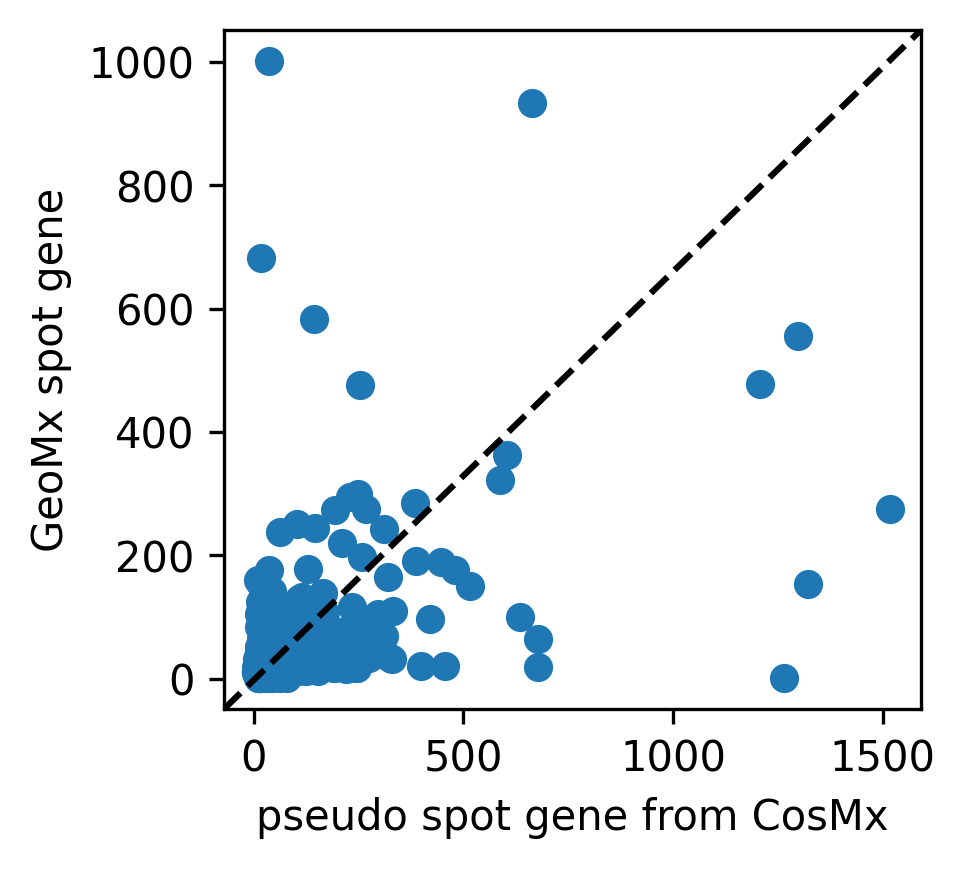

In [56]:
import matplotlib.pyplot as plt


x = []
y = []
for gene_name in common_gene_names_lst:
    x.append(pseudo_spot_gene_dic[gene_name])
    y.append(geomx_spot_gene_dic[gene_name])

fig, ax = plt.subplots(1, 1,figsize=(3,3),dpi=300)
ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--',c='k', label="1:1 line")

plt.xlabel("pseudo spot gene from CosMx")
plt.ylabel("GeoMx spot gene")
plt.scatter(x, y)
plt.show()

In [39]:
len(x)

932

In [40]:
len(y)

932

corr: 0.4243927382321116


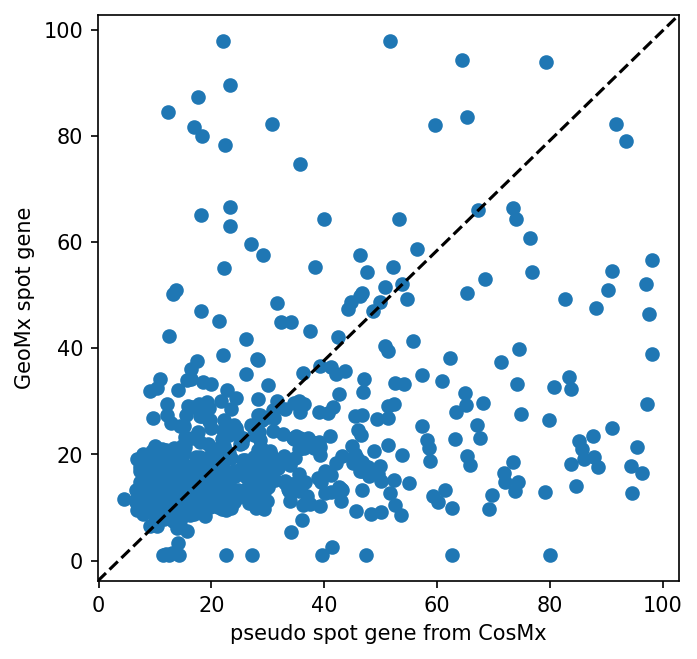

In [57]:


x = []
y = []
for gene_name in common_gene_names_lst:
    if pseudo_spot_gene_dic[gene_name] > 100:
        continue
    if geomx_spot_gene_dic[gene_name] > 100:
        continue
    x.append(pseudo_spot_gene_dic[gene_name])
    y.append(geomx_spot_gene_dic[gene_name])

corr, _ = pearsonr(x, y)
print("corr:", corr)

fig, ax = plt.subplots(1, 1,figsize=(5,5),dpi=150)
ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--',c='k', label="1:1 line")

plt.xlabel("pseudo spot gene from CosMx")
plt.ylabel("GeoMx spot gene")
plt.scatter(x, y)
plt.show()

In [42]:
kidney_hk = pd.read_csv('../kidney_hk.csv')
kidney_hk

Unnamed: 0       hks
0            1    PLA2R1
1            2    SPOCK2
2            3      MYL9
3            4     PTGDS
4            5    TGFBR2
5            6     ANXA2
6            7       DCN
7            8      FGF1
8            9      CD81
9           10       BGN
10          11     ITGB1
11          12     CALM2
12          13      ARF1
13          14  HLA-DRB1
14          15    PECAM1
15          16     HLA-A
16          17     HMGN2
17          18    CHI3L1
18          19     HLA-E
19          20       APP
20          21      CD63
21          22     DUSP1
22          23       CD9
23          24      CD59
24          25     RPL21
25          26     RPL22
26          27     RPL32
27          28       MGP

In [43]:
kidney_hk_lst = kidney_hk["hks"].tolist()

corr: 0.5320145396568767


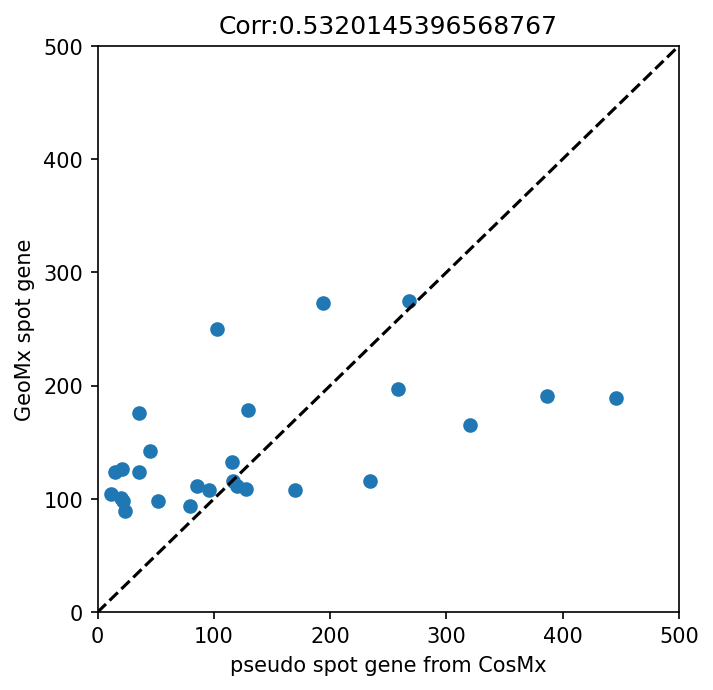

In [61]:
x = []
y = []

for gene_name in kidney_hk_lst:
    if pseudo_spot_gene_dic[gene_name] > 800:
        continue

    x.append(pseudo_spot_gene_dic[gene_name])
    y.append(geomx_spot_gene_dic[gene_name])

corr, _ = pearsonr(x, y)
print("corr:", corr)

fig, ax = plt.subplots(1, 1,figsize=(5,5),dpi=150)
ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--',c='k', label="1:1 line")

plt.xlabel("pseudo spot gene from CosMx")
plt.ylabel("GeoMx spot gene")

plt.xlim(0,500)
plt.ylim(0,500)
plt.title('Corr:' + str(corr))

plt.scatter(x, y)
plt.show()